Importing the necessary libraries


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

!pip install pmdarima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from itertools import chain

!pip install scipy
from scipy.stats import ttest_ind

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cleaning Crime Data and Replacing Null values with means.

In [125]:
fpath = '/content/drive/MyDrive/Group24Datasets/USCrimeData.csv'
crime_df = pd.read_csv(fpath)

#Dropping Unecessary Columns that we don't need
crime_df.drop('agency_code',axis=1,inplace=True)
crime_df.drop('months_reported',axis=1,inplace=True)

#Renaming Relevant columns
mapping = {'report_year': 'year', 'agency_jurisdiction': 'state'}
crime_df.rename(columns=mapping, inplace=True)

# State Name: Aurora , NZ -> NZ
# State Name: Aurora , SE -> SE
crime_df = crime_df[crime_df['state'] != 'United States']
crime_df['state'] = crime_df['state'].str.split(',').str[1].str.strip()

states = crime_df[crime_df['year']==1995]['state']
states = set(states)
states = list(states)

# For multiple entries of a state e.g Aurora, NZ and Aurora, SE
# We merge it into a single entry by taking the mean
crime_df = crime_df.groupby(['state', 'year']).mean().reset_index()
columns_to_drop = ['homicides', 'rapes', 'assaults', 'robberies']

# Drop the specified columns
crime_df.drop(columns=columns_to_drop, inplace=True)
crime_df.drop(index=crime_df[crime_df['state'] == 'Louisville'].index, inplace=True)

# Calculate means for each state
state_means = crime_df.groupby('state').mean()

# (state, 2012)
# (state, 2013)
# (state, 2014)
# (state, 2015) -> Null : mean of 2012 2013 2014
def f(row):
    # Fill NaN values without inplace=True
    if not row.isna().any():
      return row

    row.fillna(state_means.loc[row['state']], inplace=True)
    return row

# Apply the function to each row
crime_df = crime_df.apply(f, axis=1)

crime_df.head(5)

state  year     population  violent_crimes  crimes_percapita  \
0    AZ  1975  373907.333333     2242.000000        487.800000   
1    AZ  1976  370231.666667     1877.000000        438.150000   
2    AZ  1977  368366.666667     2086.000000        491.730000   
3    AZ  1978  376966.666667     2516.000000        568.230000   
4    AZ  1979  383230.666667     2862.333333        701.263333   

   homicides_percapita  rapes_percapita  assaults_percapita  \
0             6.583333        35.406667          251.033333   
1             6.640000        30.216667          243.690000   
2             8.373333        37.793333          284.090000   
3             8.080000        49.533333          318.213333   
4             6.276667        56.843333          411.996667   

   robberies_percapita  
0           194.776667  
1           157.600000  
2           161.473333  
3           192.403333  
4           226.146667

Replacing null values in income_df with means and reshaping the dataframe.

In [126]:
fpath = '/content/drive/MyDrive/Group24Datasets/USPesonalIncomeData.xlsx'
income_df = pd.read_excel(fpath)
income_df.drop(['GeoFIPS', 'Region', 'TableName', 'LineCode', 'IndustryClassification'], axis=1, inplace = True)
income_df = income_df.iloc[:180,:]
income_df.rename(
    columns = {
        'GeoName':'State'
    },
    inplace = True
)

income_df = income_df[income_df['Description'] == 'Per capita disposable personal income (dollars) 2/']

def f2(row):

    row.replace("(NA)", float("nan"), inplace=True)
    row.fillna(row[3:].mean(), inplace=True)

    return row

income_df = income_df.apply(f2, axis=1)


#Remove Asterik, strip ( California * -> California)
income_df['State'] = income_df['State'].str.replace('*', '')
income_df['State'] = income_df['State'].str.strip()

melted_income_df = pd.melt(income_df, id_vars=['State', 'Description', 'Unit'], var_name='Year', value_name='Per Capita Income')

melted_income_df.head(5)



State                                        Description     Unit  \
0  United States  Per capita disposable personal income (dollars...  Dollars   
1        Alabama  Per capita disposable personal income (dollars...  Dollars   
2         Alaska  Per capita disposable personal income (dollars...  Dollars   
3        Arizona  Per capita disposable personal income (dollars...  Dollars   
4       Arkansas  Per capita disposable personal income (dollars...  Dollars   

   Year  Per Capita Income  
0  1948        1317.000000  
1  1948         830.000000  
2  1948       24943.111111  
3  1948        1252.000000  
4  1948         836.000000

Reshaping the unemployment dataframes.

In [127]:
fpath = '/content/drive/MyDrive/Group24Datasets/USUnemploymentData.xls'
unemployment_df = pd.read_excel(fpath, sheet_name='States')
# Extract the relevant rows and columns
unemployment_df = unemployment_df.iloc[6:57, :]


# Calculate the number of columns
num_columns = len(unemployment_df.columns)

# Generate a list of years starting from 1980
years = list(range(1980, 1980 + num_columns - 2))

# Replace the unnamed columns with the generated years
unemployment_df.columns = ['Fips', 'State', *years]
unemployment_df.reset_index(inplace=True)

unemployment_df.drop('index', axis = 1, inplace=True)

# Melt the DataFrame to convert it from wide to long format
melted_df = pd.melt(unemployment_df, id_vars=['Fips', 'State'], var_name='Year', value_name='Unemployment Rate')

# Display the reshaped DataFrame
melted_df.head(5)


Fips       State  Year  Unemployment Rate
0  01000     Alabama  1980                8.9
1  02000      Alaska  1980                9.6
2  04000     Arizona  1980                6.6
3  05000    Arkansas  1980                7.6
4  06000  California  1980                6.8

Mapping the State Names in each dataframe to a single mapping. Reshaping the dataframes.

In [128]:
state_mapping = {
    'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'DC': 'District of Columbia',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'IL': 'Illinois', 'IN': 'Indiana',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'NC': 'North Carolina', 'NE': 'Nebraska',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'TN': 'Tennessee', 'TX': 'Texas',
    'UT': 'Utah', 'VA': 'Virginia', 'WA': 'Washington', 'WI': 'Wisconsin'
}

crime_df['state'] = crime_df['state'].replace(state_mapping)

income_states = set(income_df['State'].unique())
crime_states = set(crime_df['state'].unique())
unemployment_states = set(unemployment_df['State'].unique())

# Find the common states
common_states = income_states & crime_states & unemployment_states

print("Common States:", common_states)

income_df_filtered = income_df[income_df['State'].isin(common_states)]
crime_df_filtered = crime_df[crime_df['state'].isin(common_states)]
unemployment_df_filtered = unemployment_df[unemployment_df['State'].isin(common_states)]

income_df_filtered = pd.melt(income_df_filtered, id_vars=['State', 'Description', 'Unit'], var_name='Year', value_name='Per Capita Income')
unemployment_df_filtered = pd.melt(unemployment_df_filtered, id_vars=['Fips', 'State'], var_name='Year', value_name='Unemployment Rate')




Common States: {'Utah', 'North Carolina', 'Colorado', 'Minnesota', 'Illinois', 'Pennsylvania', 'Michigan', 'Indiana', 'Virginia', 'Wisconsin', 'New York', 'District of Columbia', 'Ohio', 'Kansas', 'New Mexico', 'Hawaii', 'Washington', 'New Jersey', 'Kentucky', 'Arizona', 'Georgia', 'Tennessee', 'Texas', 'California', 'Maryland', 'Oklahoma', 'Missouri', 'Louisiana', 'Nebraska', 'Nevada', 'Massachusetts', 'Florida', 'Oregon'}


Merging the three dataframes into a single dataframe on state and year.

In [129]:
# Merge income_df, unemployment_df, and crime_df on the basis of (state, year)
merged_df = pd.merge(melted_income_df, unemployment_df_filtered, left_on=['State', 'Year'], right_on=['State', 'Year'])
merged_df = pd.merge(merged_df, crime_df_filtered, left_on=['State', 'Year'], right_on=['state', 'year'])

# Drop unnecessary columns
merged_df = merged_df.drop(['state'], axis=1)

# Display the merged DataFrame without null values
merged_df.drop(['Description','Unit','Fips','year'],axis=1 , inplace=True)

merged_df.head(5)

State  Year  Per Capita Income  Unemployment Rate  \
0               Arizona  1980             8606.0                6.6   
1            California  1980            10439.0                6.8   
2              Colorado  1980             9590.0                5.8   
3  District of Columbia  1980            11388.0                7.4   
4               Florida  1980             8980.0                6.1   

      population  violent_crimes  crimes_percapita  homicides_percapita  \
0  418017.333333     3472.000000        743.440000               10.490   
1  815030.444444    11609.666667       1329.897778               21.440   
2  323783.500000     3399.000000        967.845000               13.275   
3  635233.000000    12772.000000       2010.600000               31.480   
4  409904.800000     7238.000000       1929.644000               27.094   

   rapes_percapita  assaults_percapita  robberies_percapita  
0        52.223333          440.896667           239.826667  
1        86.035556          536.422222           686.003333  
2       101.950000          499.945000           352.665000  
3        69.110000          509.420000          1400.590000  
4       104.014000          925.020000           873.516000

Adding GINI index to the merged Data frame.

In [130]:
#Adding GINI INDEX Data
fpath = '/content/drive/MyDrive/Group24Datasets/GiniCumulative.xls'
gini_df = pd.read_excel(fpath)


In [131]:
filtered_gini_df = gini_df.iloc[10:,:]
filtered_gini_df.columns = ['Year', 'Gini Index']
filtered_gini_df['Year'] = filtered_gini_df['Year'].astype(str).str[:4]
filtered_gini_df.reset_index(inplace=True)
filtered_gini_df.drop('index',axis=1,inplace=True)

filtered_gini_df['Year'] = filtered_gini_df['Year'].astype(int)

merged_df['Year'] = merged_df['Year'].astype(int)

merged_df = pd.merge(merged_df, filtered_gini_df, how='inner', left_on='Year', right_on='Year')
merged_df['Gini Index'] = merged_df['Gini Index'].astype(int)

merged_df.head(5)


State  Year  Per Capita Income  Unemployment Rate  \
0               Arizona  1980             8606.0                6.6   
1            California  1980            10439.0                6.8   
2              Colorado  1980             9590.0                5.8   
3  District of Columbia  1980            11388.0                7.4   
4               Florida  1980             8980.0                6.1   

      population  violent_crimes  crimes_percapita  homicides_percapita  \
0  418017.333333     3472.000000        743.440000               10.490   
1  815030.444444    11609.666667       1329.897778               21.440   
2  323783.500000     3399.000000        967.845000               13.275   
3  635233.000000    12772.000000       2010.600000               31.480   
4  409904.800000     7238.000000       1929.644000               27.094   

   rapes_percapita  assaults_percapita  robberies_percapita  Gini Index  
0        52.223333          440.896667           239.826667          34  
1        86.035556          536.422222           686.003333          34  
2       101.950000          499.945000           352.665000          34  
3        69.110000          509.420000          1400.590000          34  
4       104.014000          925.020000           873.516000          34

# **EDA**

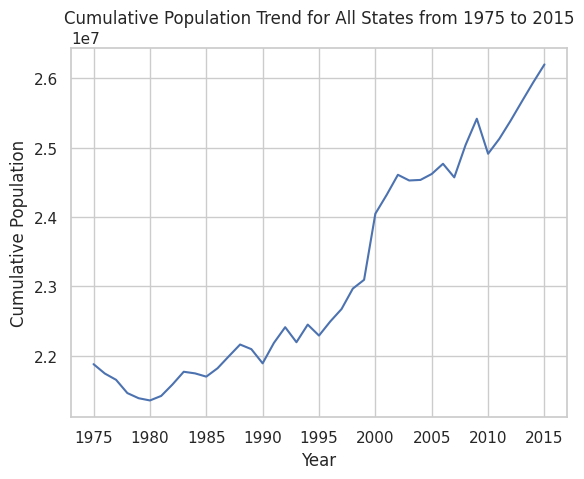

In [132]:
#cumulative population trend for US in 32 states

# Group by year and calculate the sum of population for all states
grouped_by_population = crime_df.groupby('year')['population'].sum().reset_index()

#Plotting the cumulative population trend
plt.plot(grouped_by_population['year'], grouped_by_population['population'])
plt.xlabel('Year')
plt.ylabel('Cumulative Population')
plt.title('Cumulative Population Trend for All States from 1975 to 2015')
plt.show()

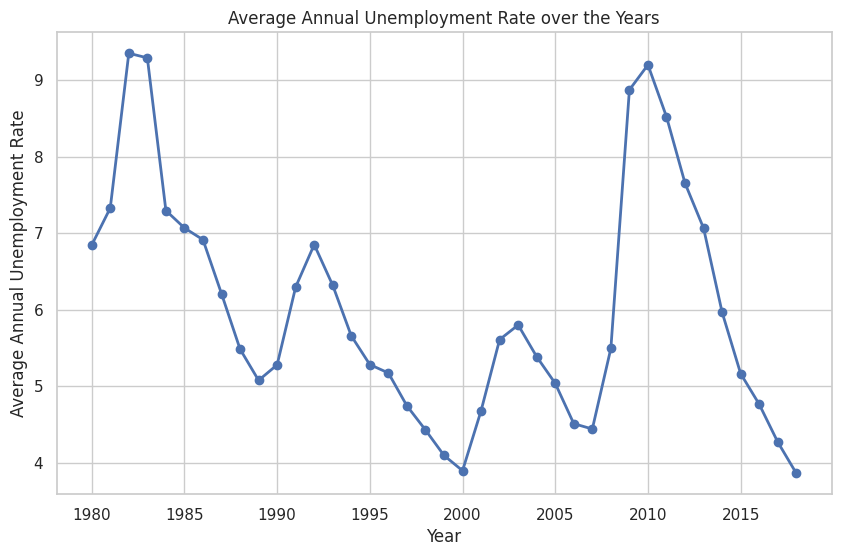

In [133]:

# Assuming df is your DataFrame
plt.figure(figsize=(10, 6))

# Group by 'Year' and calculate the mean of 'Unemployment Rate'
unemployment_df_mean = unemployment_df_filtered.groupby('Year')['Unemployment Rate'].mean()

# Plotting the line plot
plt.plot(unemployment_df_mean.index, unemployment_df_mean, marker='o', linestyle='-', linewidth=2)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Average Annual Unemployment Rate')
plt.title('Average Annual Unemployment Rate over the Years')

# Show the plot
plt.show()


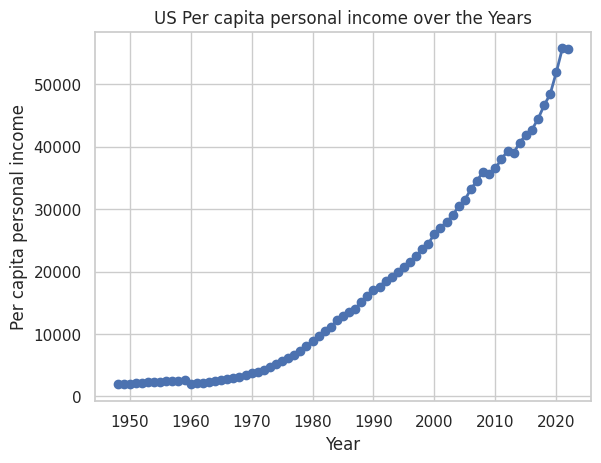

In [134]:
df = income_df_filtered.groupby('Year')['Per Capita Income'].mean()

plt.plot(df.index, df, marker='o', linestyle='-', linewidth=2)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Per capita personal income')
plt.title('US Per capita personal income over the Years')

# Show the plot
plt.show()

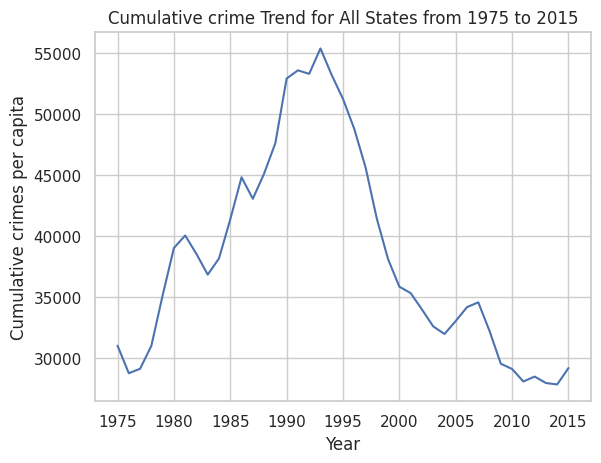

In [135]:
grouped_by_crime = crime_df.groupby('year')['crimes_percapita'].sum().reset_index()

#Plotting the cumulative crime trend
plt.plot(grouped_by_crime['year'], grouped_by_crime['crimes_percapita'])
plt.xlabel('Year')
plt.ylabel('Cumulative crimes per capita')
plt.title('Cumulative crime Trend for All States from 1975 to 2015')
plt.show()

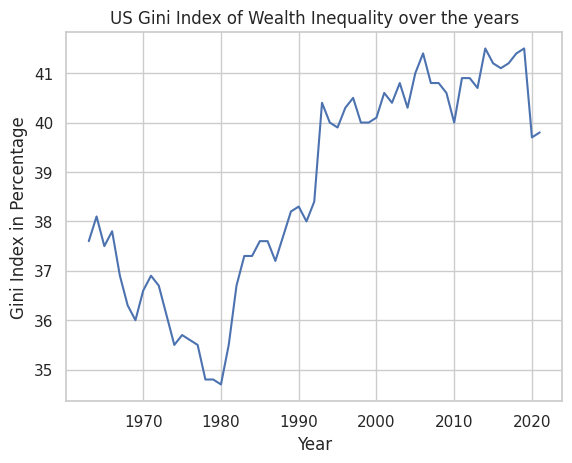

In [136]:

sns.lineplot(x=filtered_gini_df['Year'], y=filtered_gini_df['Gini Index'])
plt.title("US Gini Index of Wealth Inequality over the years")
plt.ylabel('Gini Index in Percentage')
plt.show()

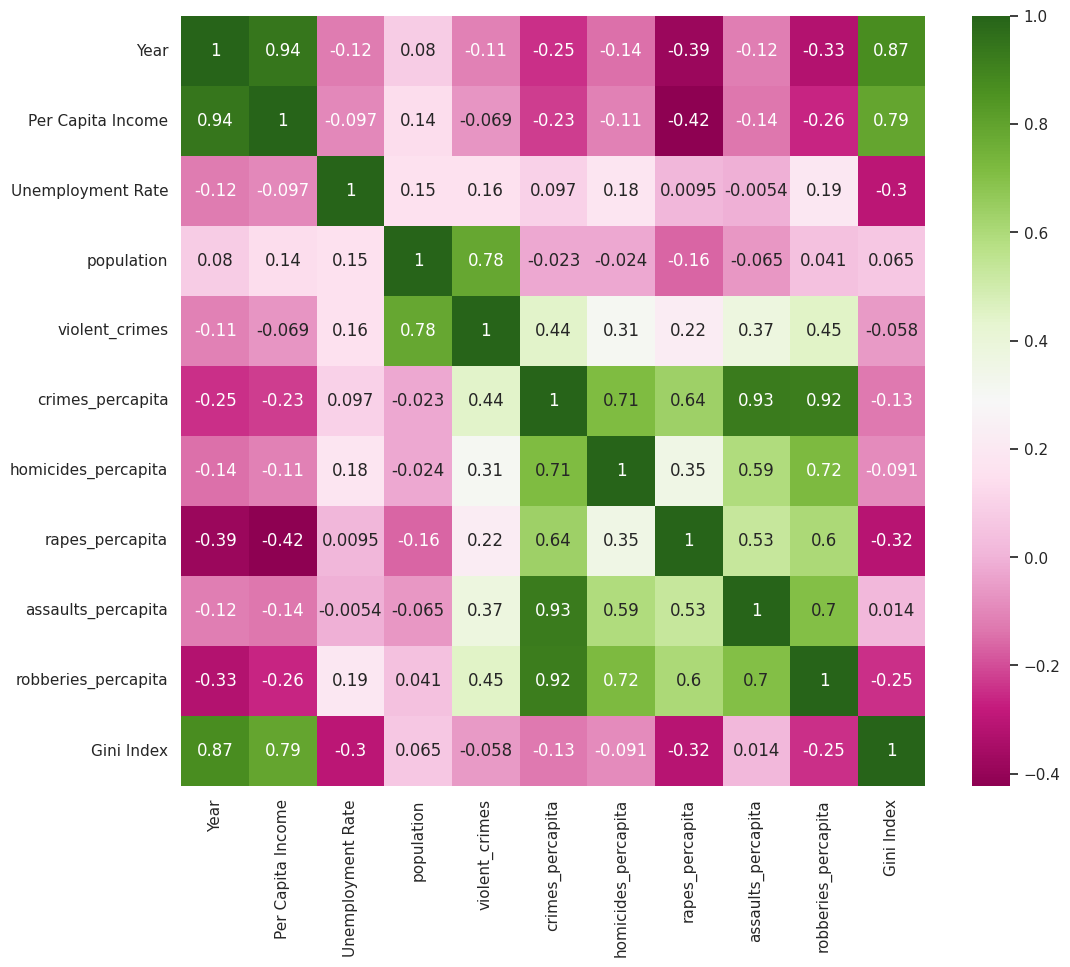

In [137]:
# Increase the size of the heatmap
plt.figure(figsize=(12, 10))
# Create the heatmap
sns.heatmap(data=merged_df.corr(), annot=True, cmap='PiYG')
# Show the plot
plt.show()

Analyzing ....

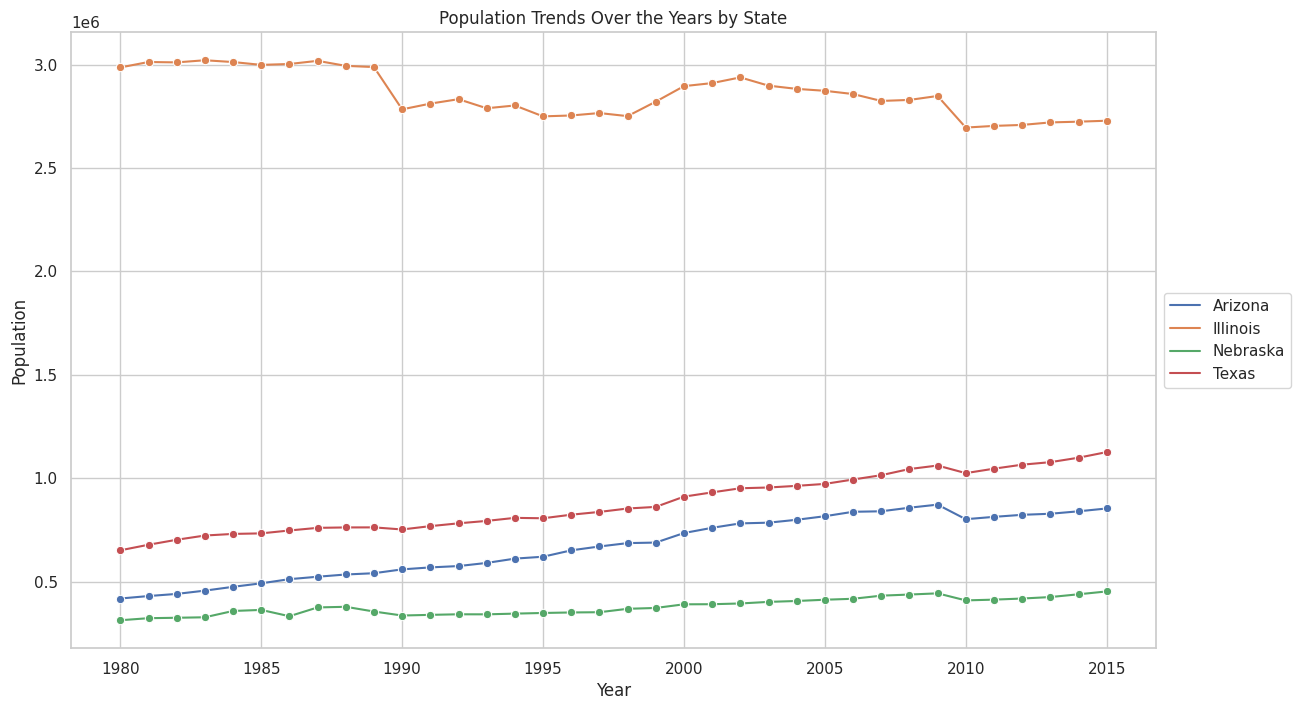

In [138]:
plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='population', hue='State', data=merged_df[merged_df['State'].isin(['Arizona', 'Nebraska', 'Texas', 'Illinois'])], marker='o')
plt.title('Population Trends Over the Years by State')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Analyzing the trends of different types of crimes over the years.

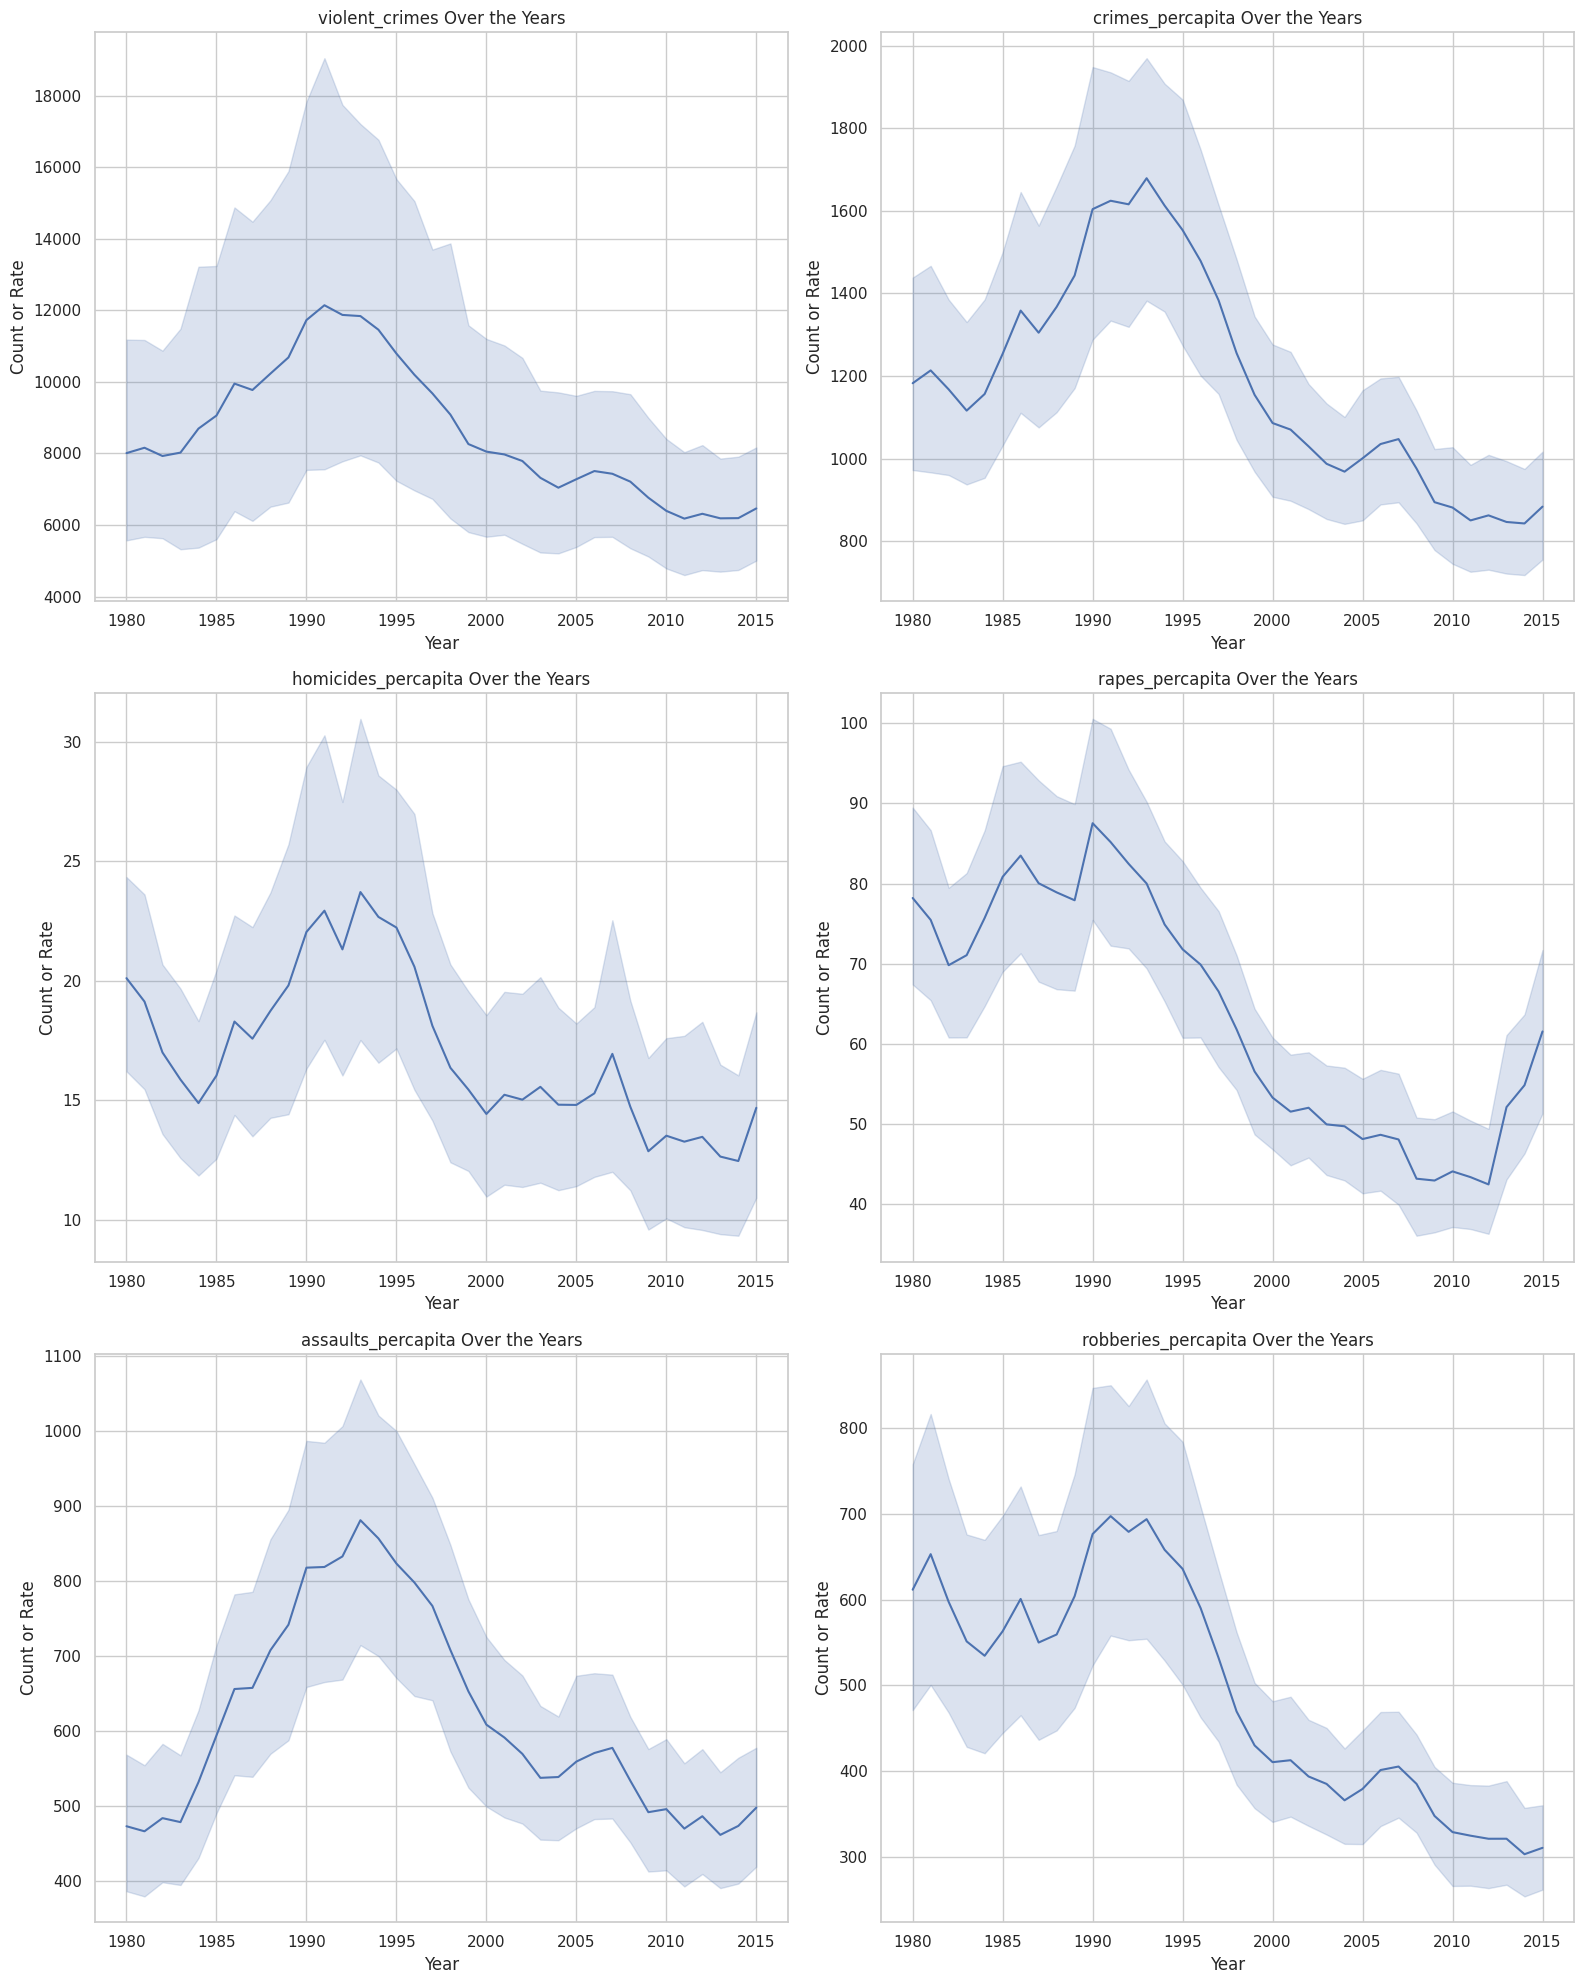

In [139]:
crime_metrics = ['violent_crimes', 'crimes_percapita', 'homicides_percapita', 'rapes_percapita',
                 'assaults_percapita', 'robberies_percapita']

# Set the style
sns.set(style="whitegrid")

# Create subplots for each crime metric
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 20))

for i, ax in enumerate(axes.flatten()):
    sns.lineplot(x='Year', y=crime_metrics[i], data=merged_df, ax=ax)
    ax.set_title(f'{crime_metrics[i]} Over the Years')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count or Rate')

# Adjust layout
plt.tight_layout()
plt.show()

# Research Question 3: Relationship between unemployment and crime rates

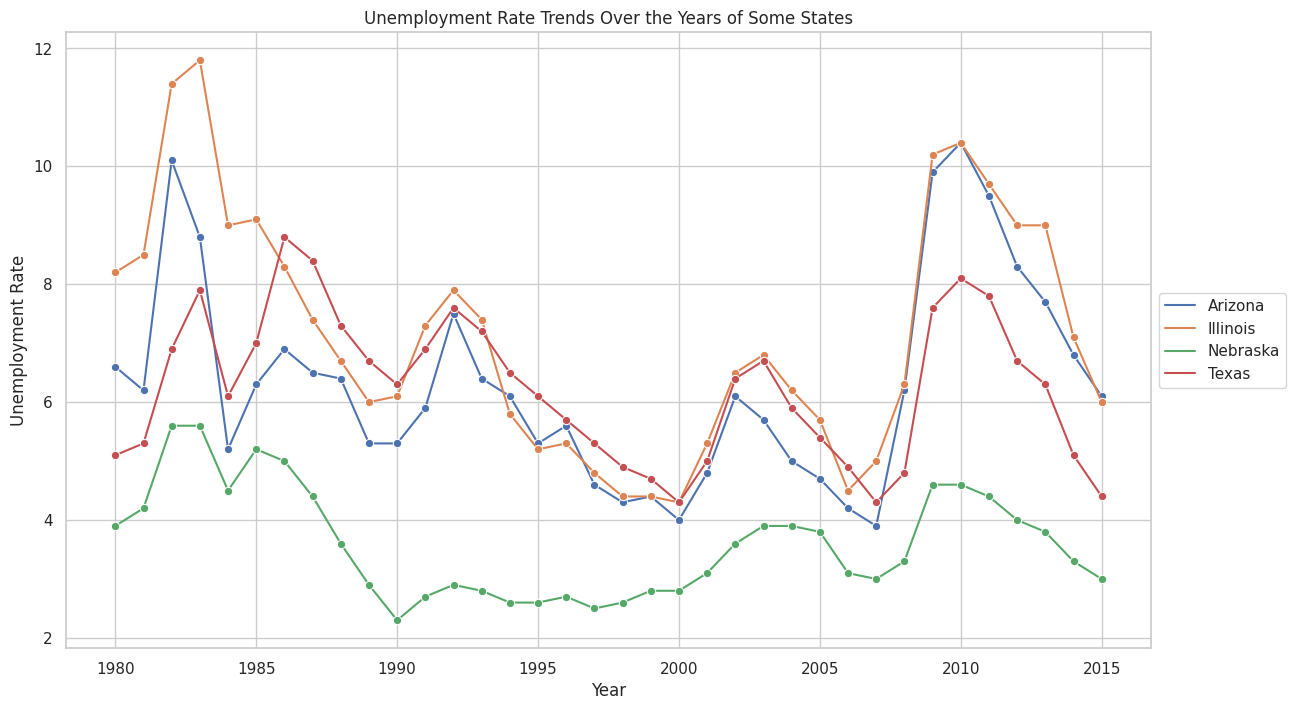

In [140]:

plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='Unemployment Rate', hue='State', data=merged_df[merged_df['State'].isin(['Arizona', 'Nebraska', 'Texas', 'Illinois'])], marker='o')
plt.title('Unemployment Rate Trends Over the Years of Some States')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Analyzing the robberies after the economic depression of 2007-2008

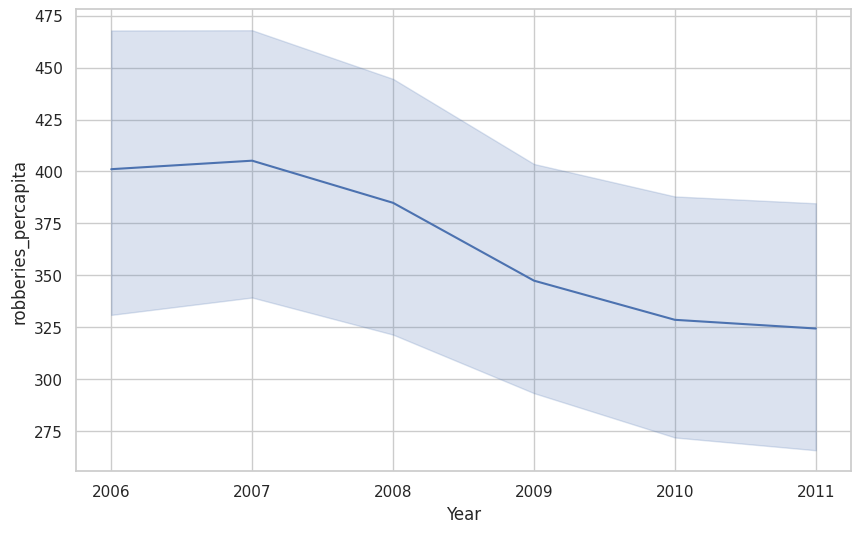

In [141]:
year_data = merged_df[merged_df['Year'].isin([2006,2007,2008,2009,2010,2011])]
plt.figure(figsize=(10, 6))
sns.lineplot(x=year_data['Year'],y=year_data['robberies_percapita'])


# Show the plot
plt.show()

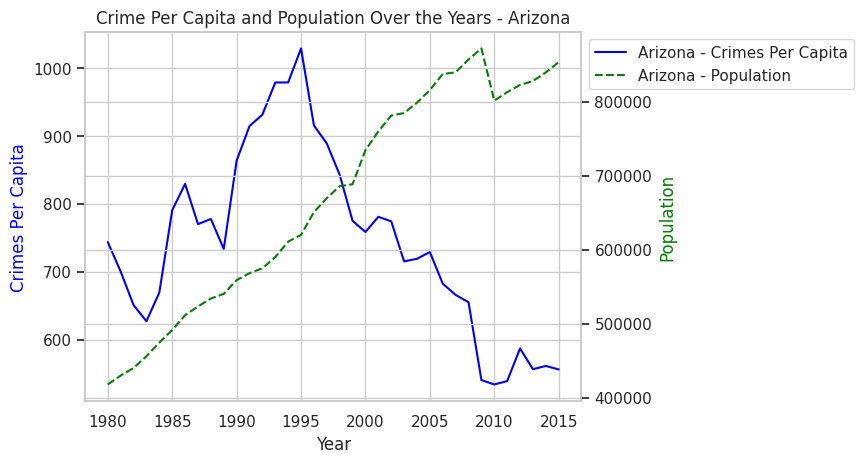

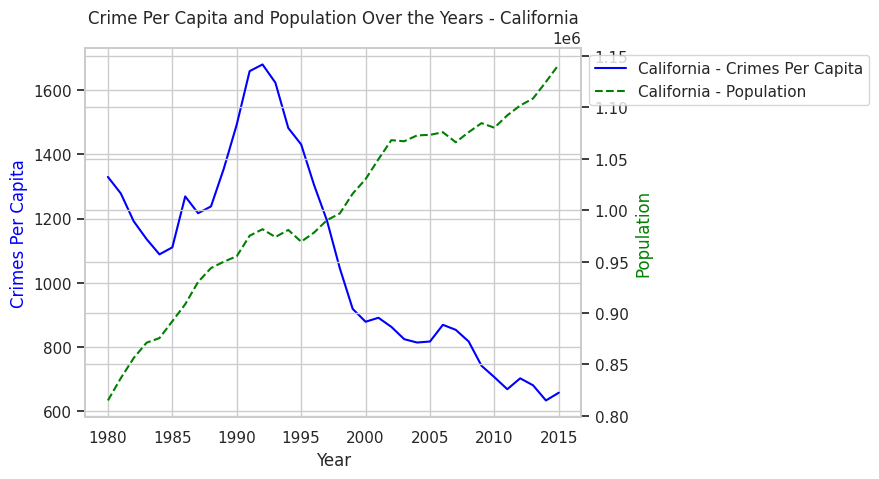

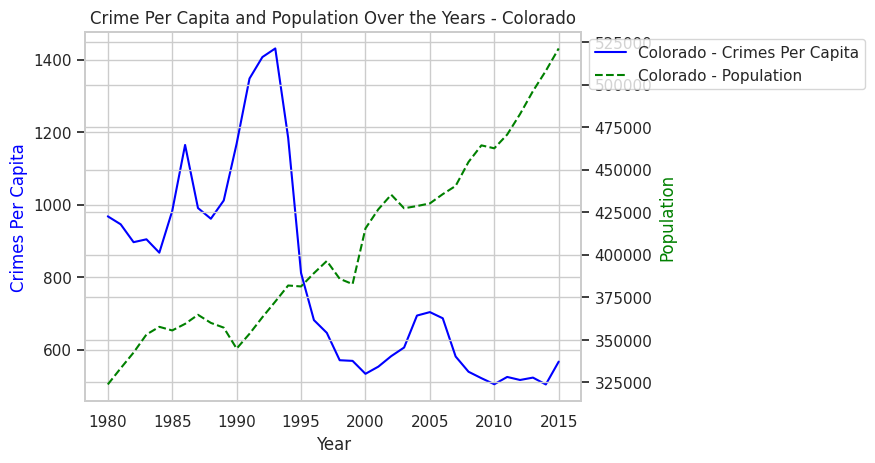

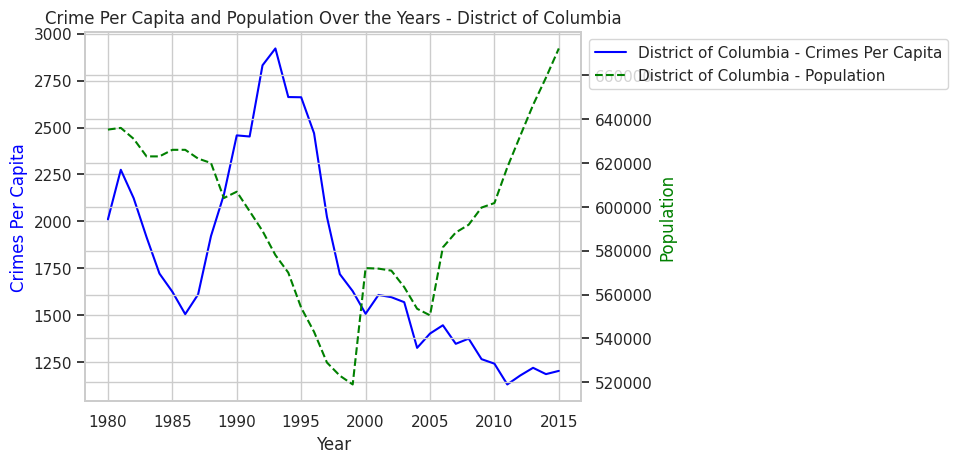

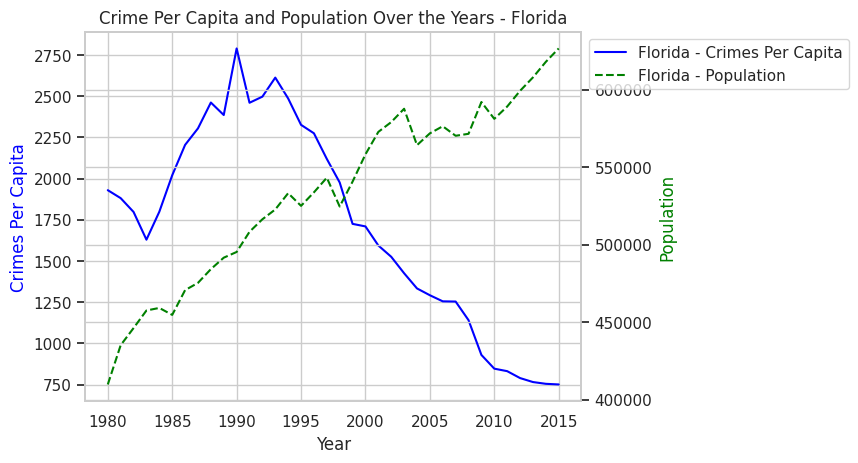

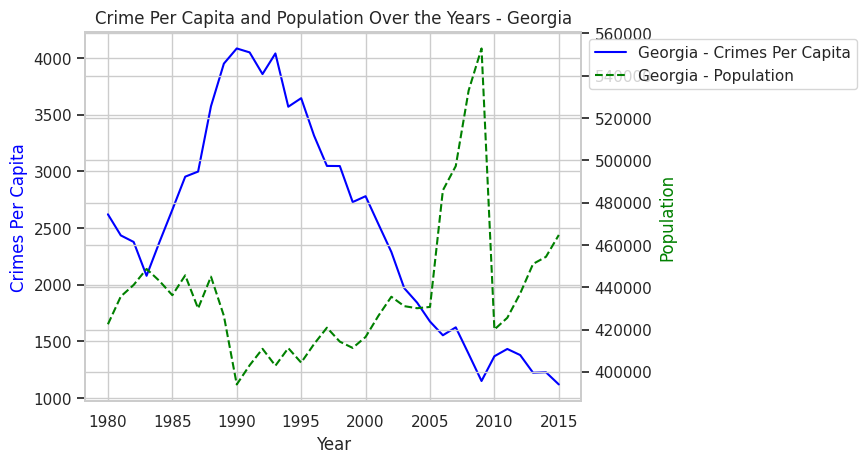

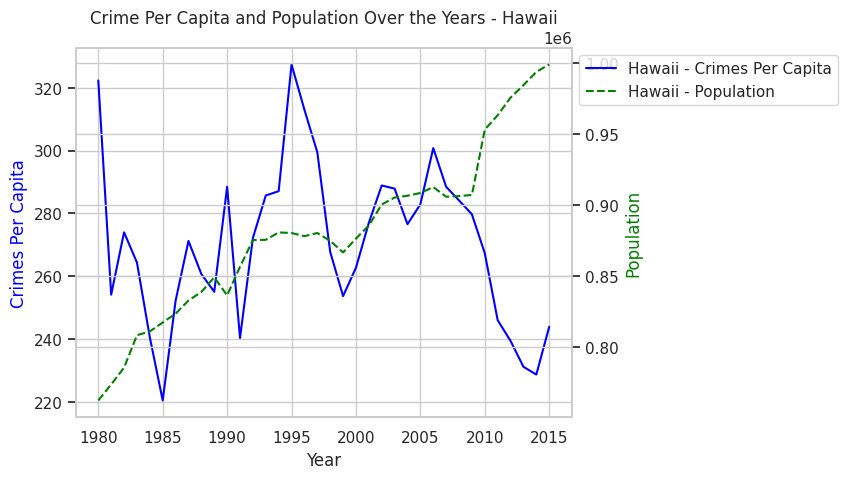

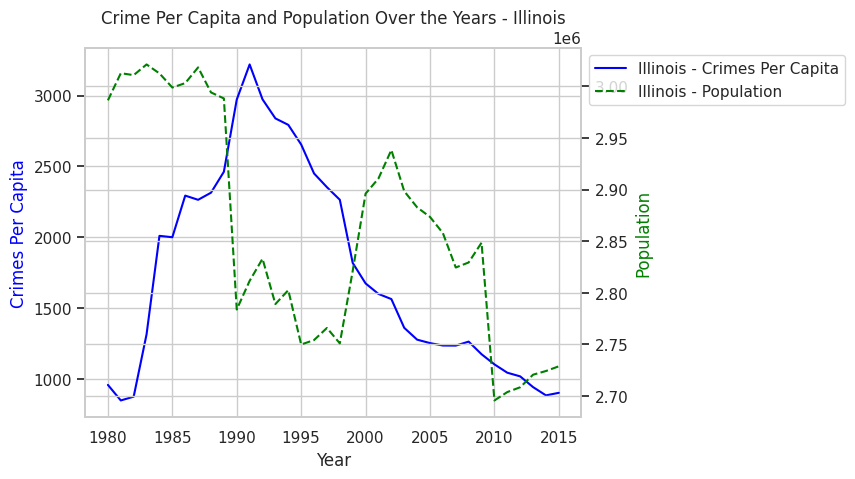

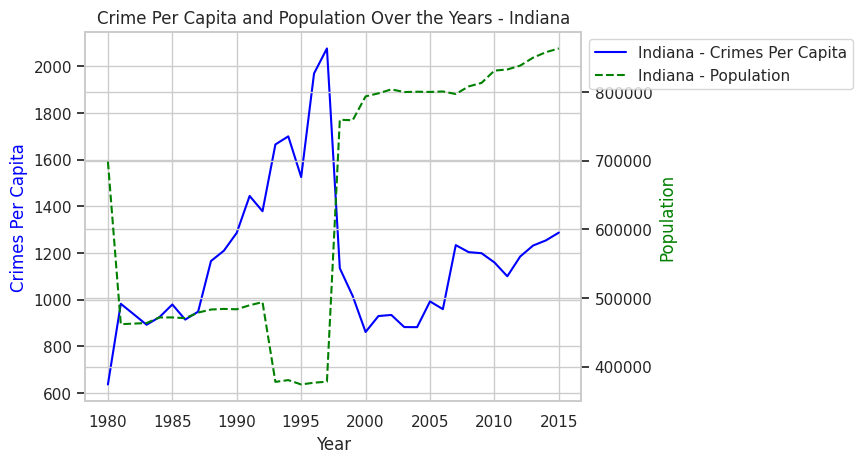

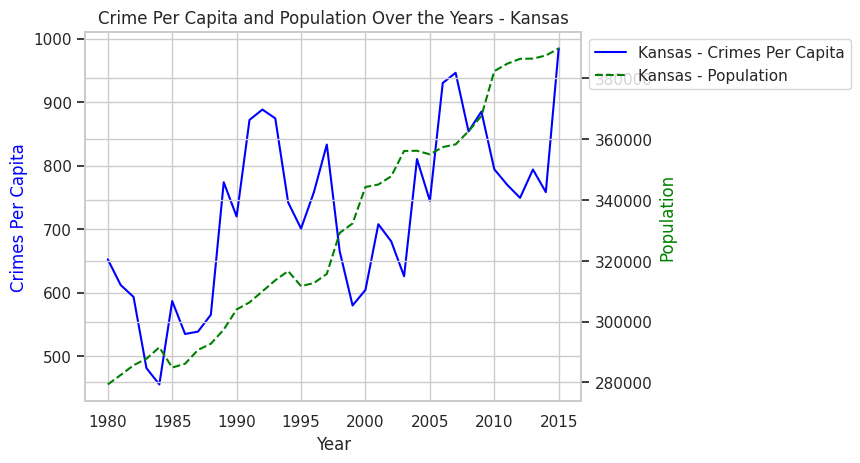

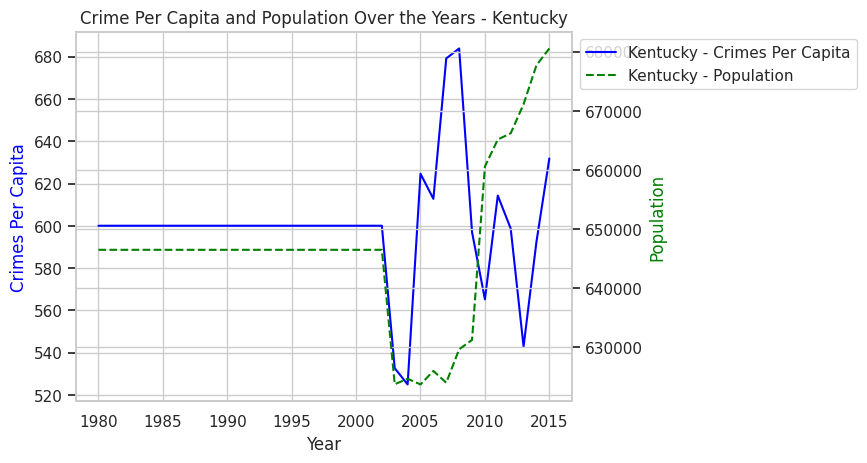

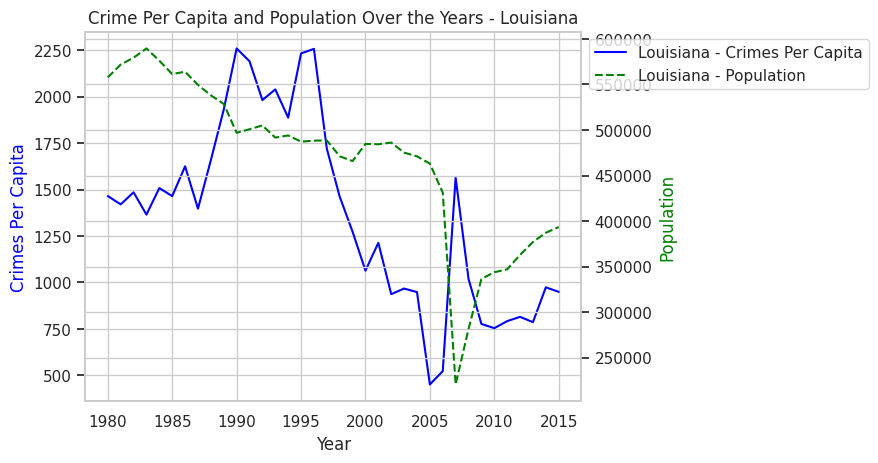

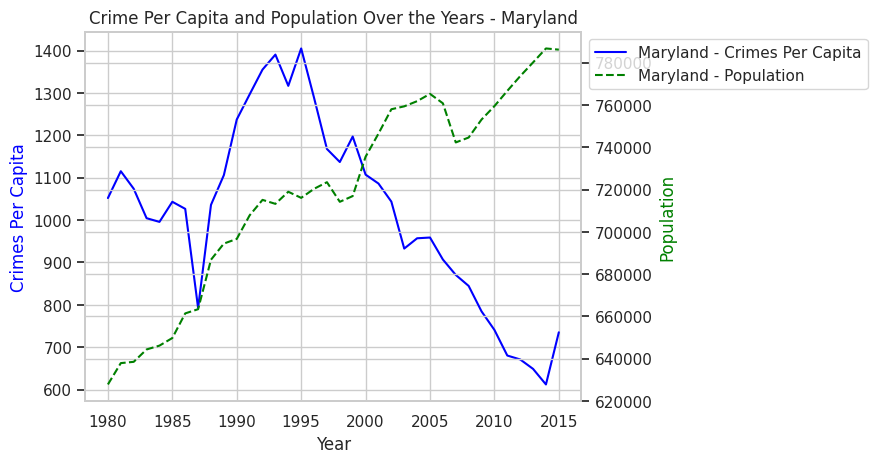

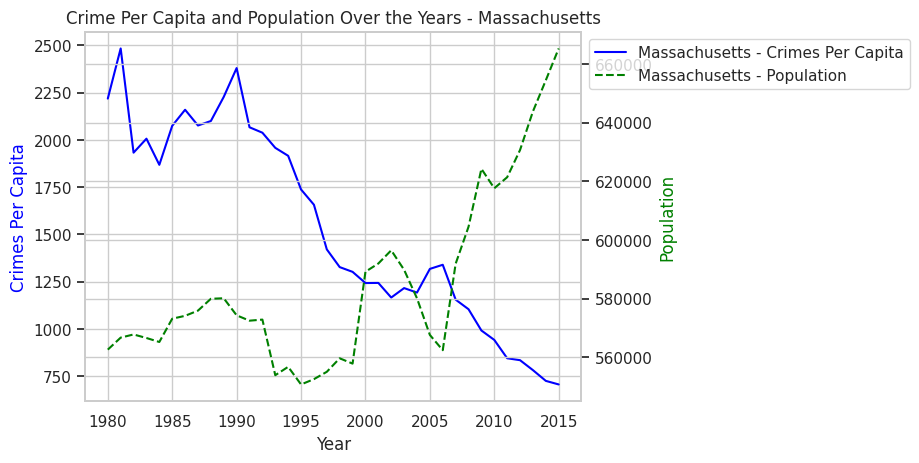

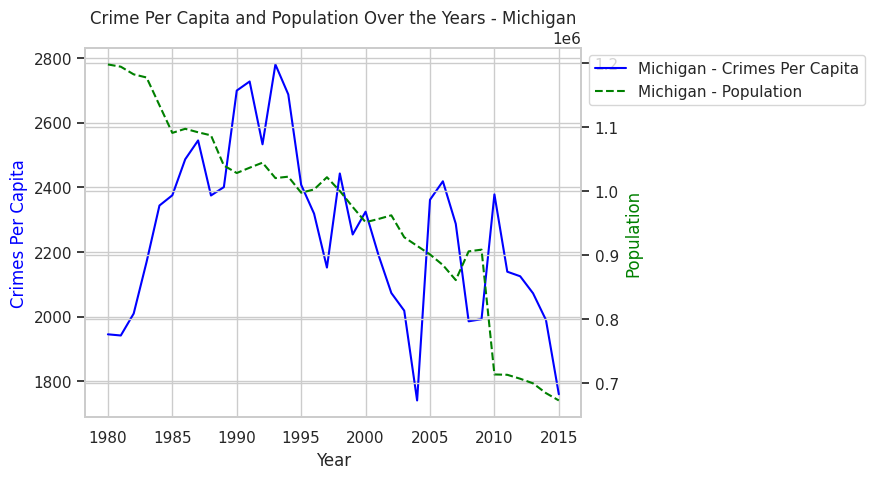

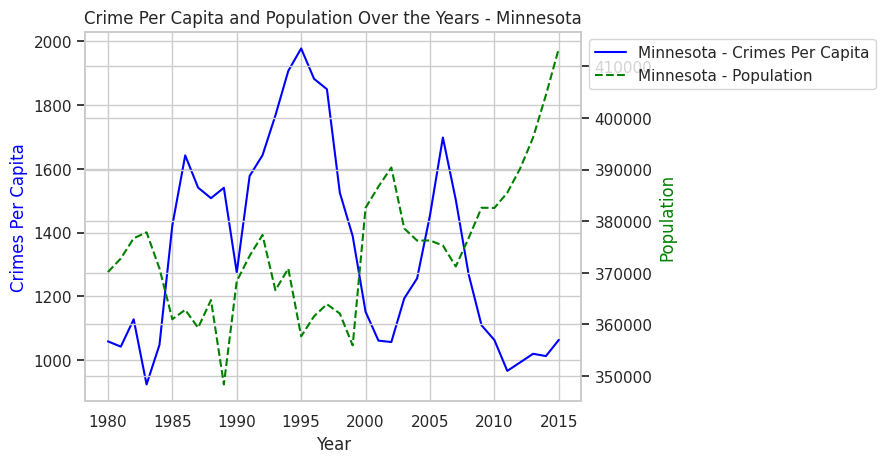

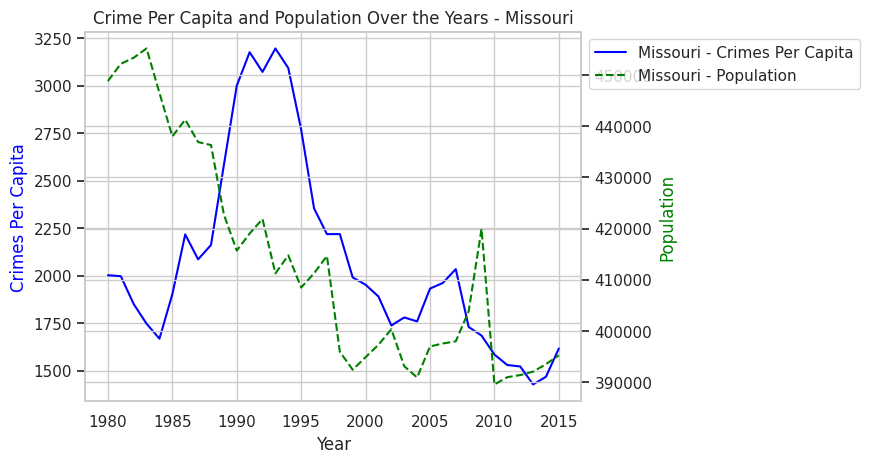

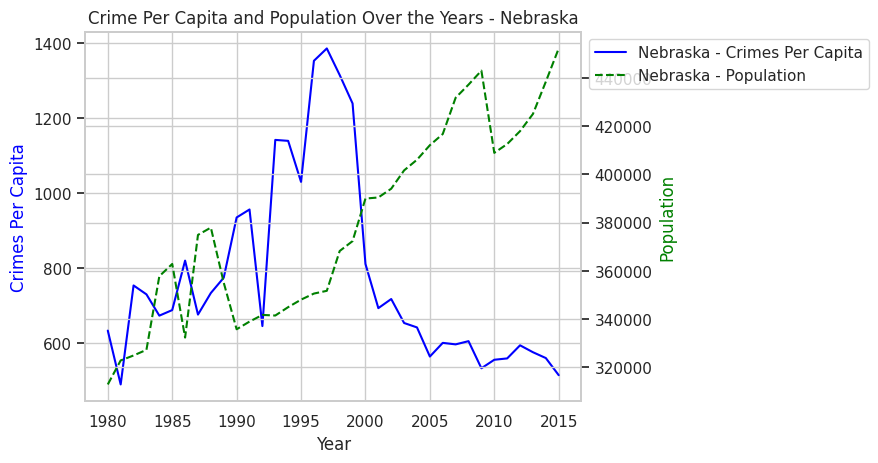

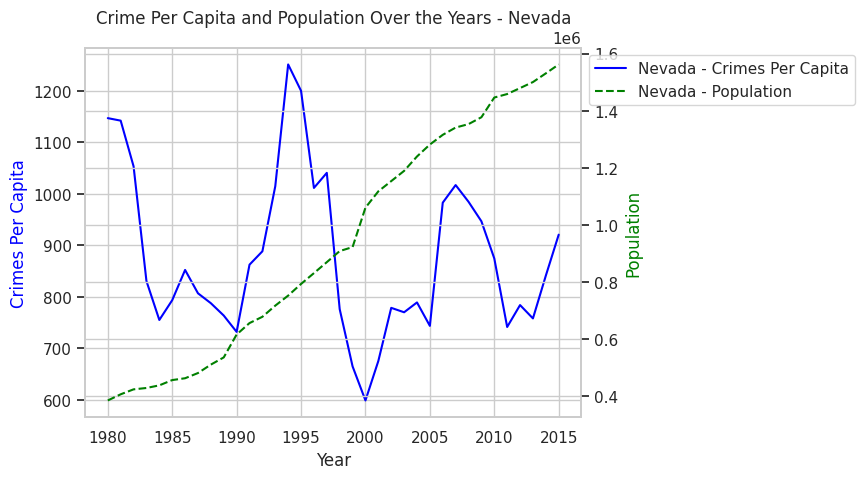

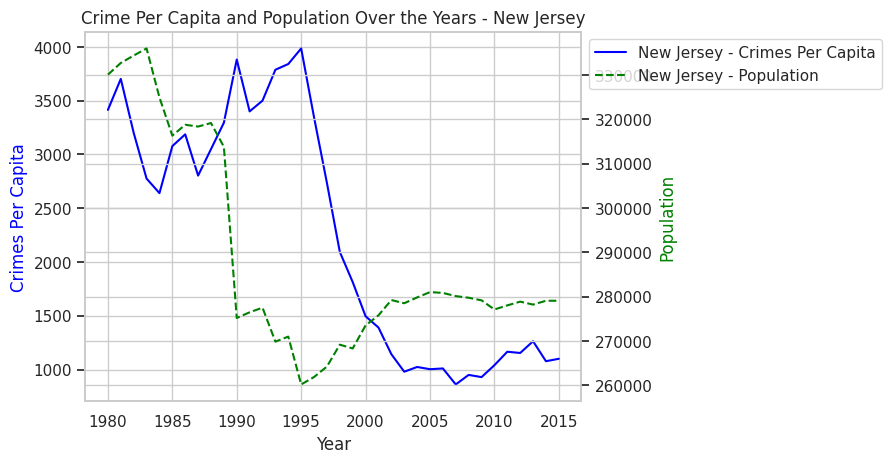

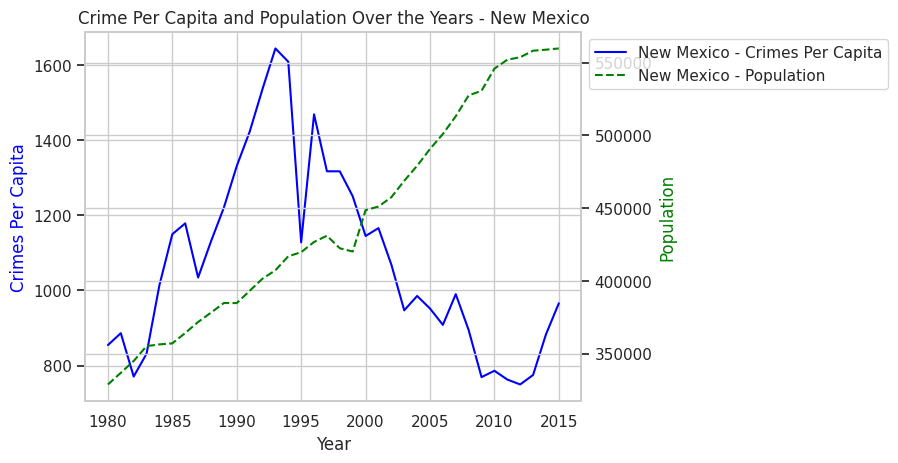

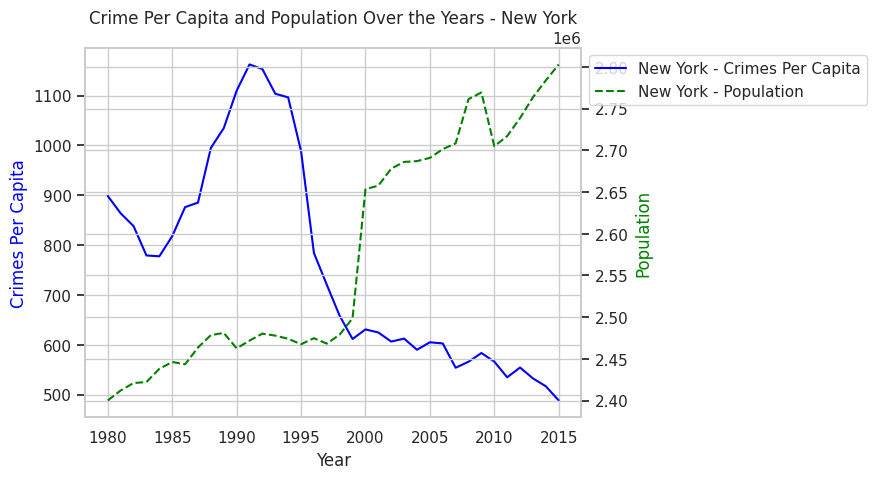

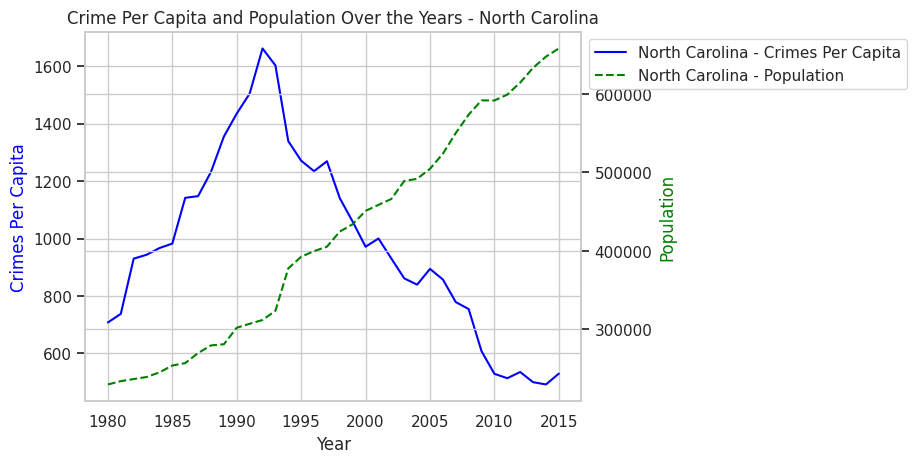

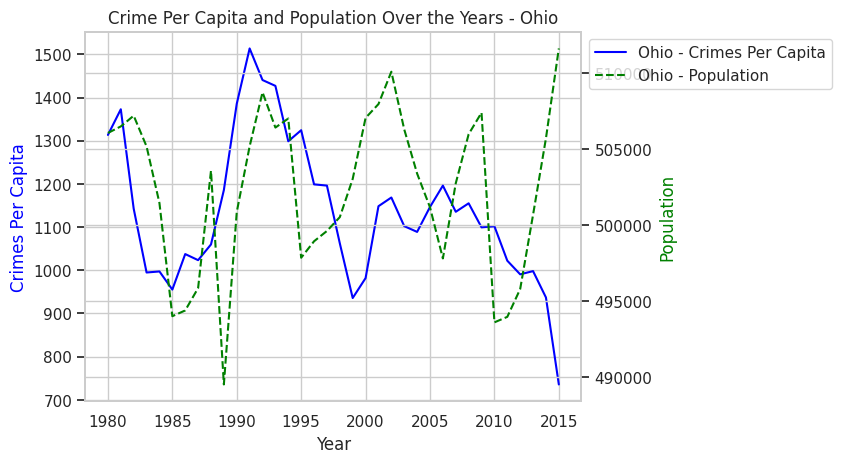

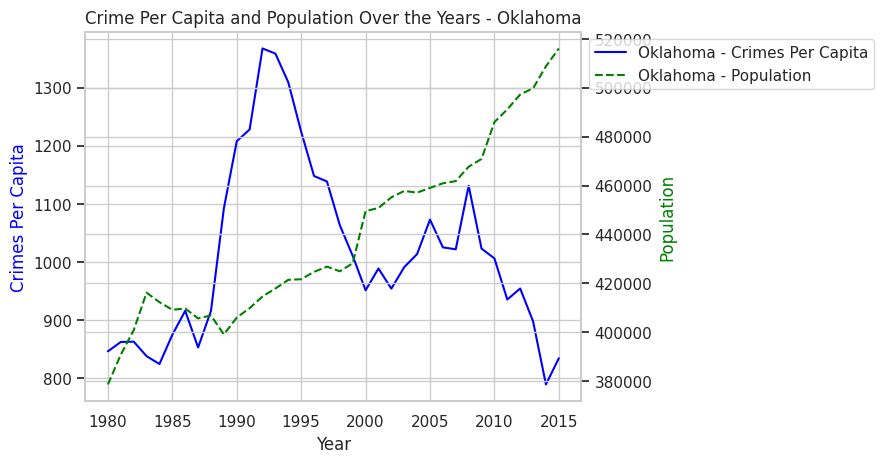

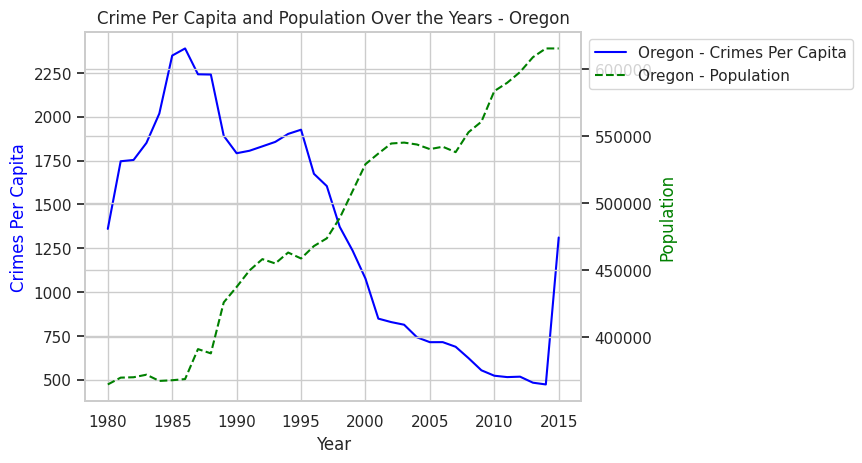

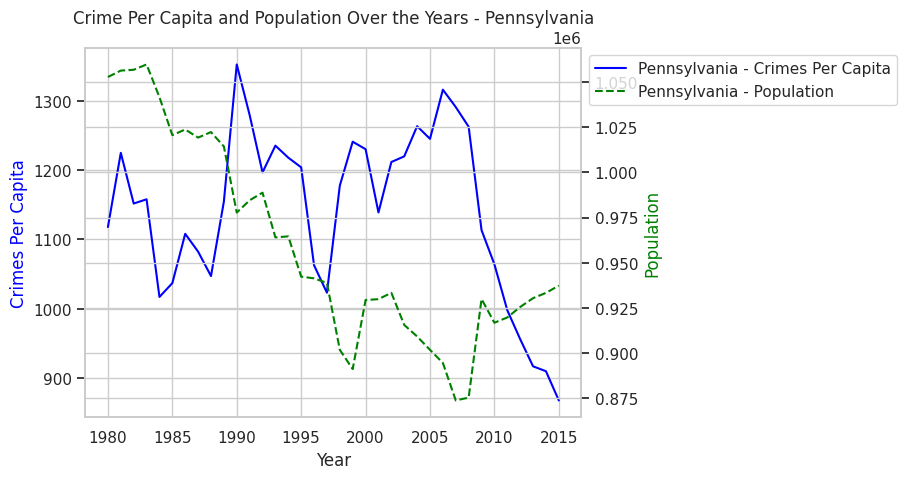

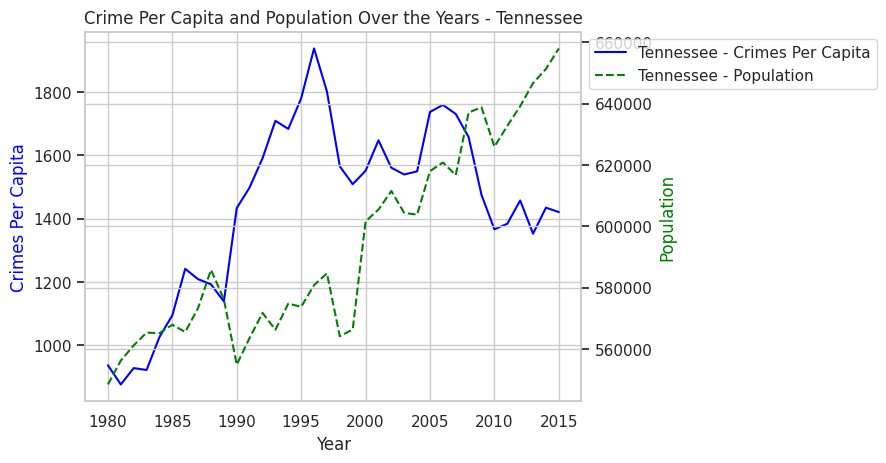

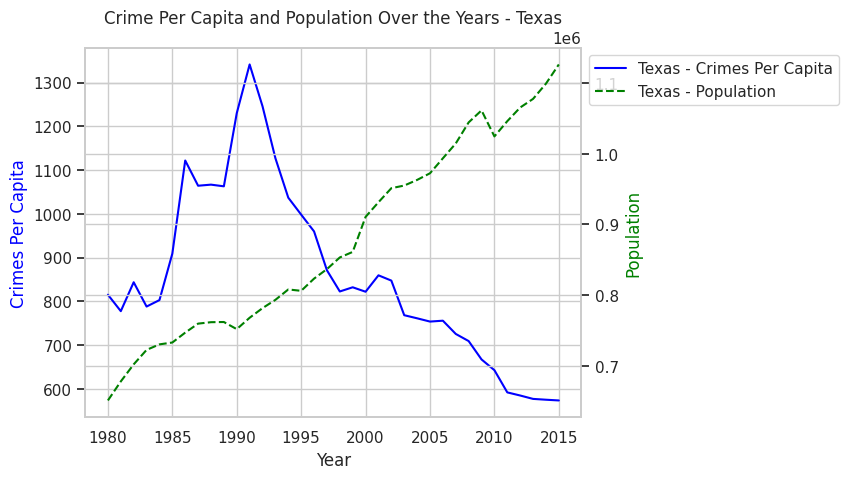

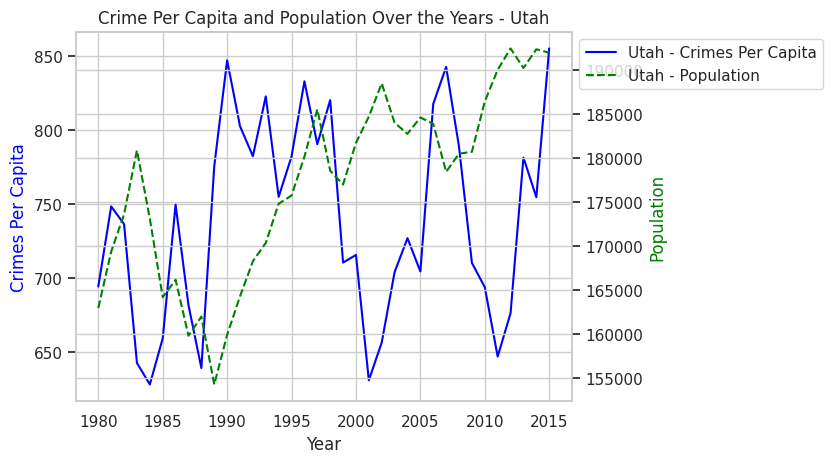

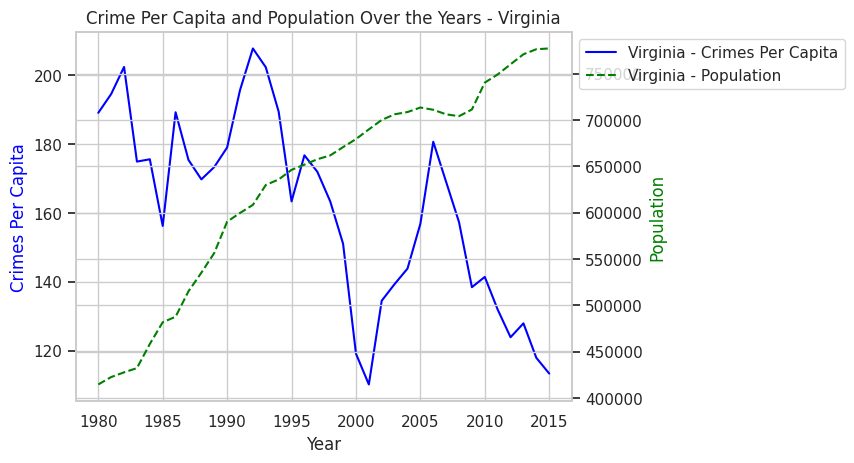

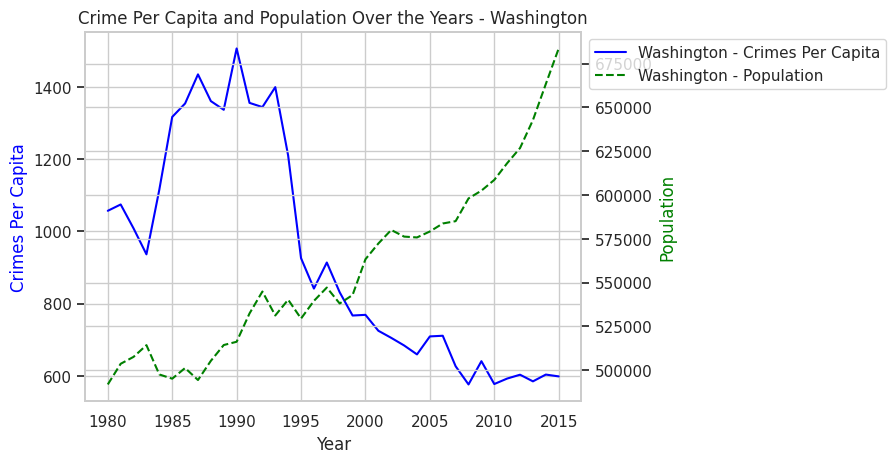

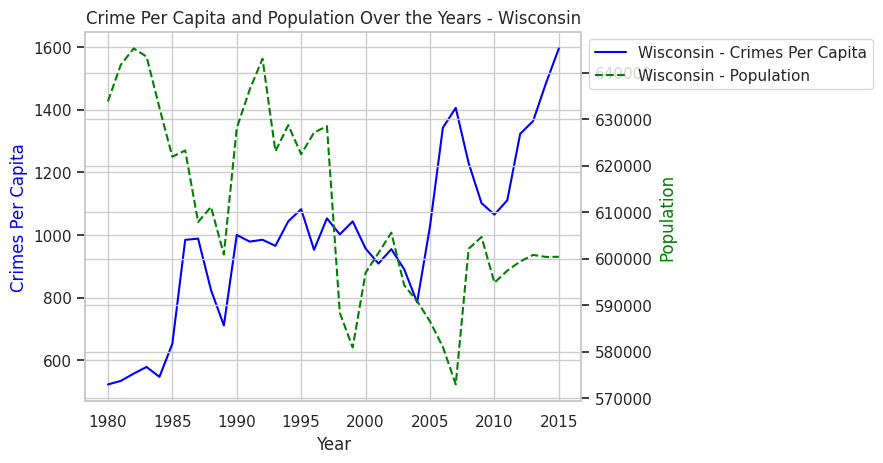

In [142]:
def plot_population_x_crime(state_data):
    # Plotting
    fig, ax1 = plt.subplots()

    # Plot crimes per capita on the primary y-axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Crimes Per Capita', color='blue')
    ax1.plot(state_data['Year'], state_data['crimes_percapita'], label=f'{state_data["State"].iloc[0]} - Crimes Per Capita', color='blue')

    # Create a secondary y-axis for population
    ax2 = ax1.twinx()
    ax2.set_ylabel('Population', color='green')
    ax2.plot(state_data['Year'], state_data['population'], label=f'{state_data["State"].iloc[0]} - Population', linestyle='dashed', color='green')

    # Set title
    plt.title(f'Crime Per Capita and Population Over the Years - {state_data["State"].iloc[0]}')

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.show()

for state in merged_df['State'].unique():
    state_data = merged_df[merged_df['State'] == state]
    plot_population_x_crime(state_data)

# **Machine Learning**

In [143]:
new_df = merged_df.groupby('Year').sum()
new_df

Per Capita Income  Unemployment Rate    population  violent_crimes  \
Year                                                                       
1980           292554.0              225.9  2.135399e+07   264325.141941   
1981           321702.0              241.9  2.141916e+07   269282.859402   
1982           343239.0              308.7  2.158425e+07   261666.506227   
1983           366974.0              306.7  2.176791e+07   264801.926862   
1984           402070.0              240.8  2.174468e+07   286947.002259   
1985           424582.0              233.3  2.169767e+07   299003.684799   
1986           445778.0              228.2  2.181843e+07   328472.345910   
1987           462867.0              204.9  2.199117e+07   322579.808608   
1988           499819.0              181.0  2.216090e+07   337718.550672   
1989           531890.0              167.5  2.209384e+07   352626.971306   
1990           560834.0              174.2  2.188940e+07   387106.422100   
1991           579633.0              207.8  2.218420e+07   400800.820513   
1992           612210.0              226.1  2.241078e+07   391866.257814   
1993           632024.0              208.5  2.219427e+07   390809.596703   
1994           656318.0              186.7  2.244847e+07   378213.551465   
1995           683687.0              174.3  2.228999e+07   356217.233211   
1996           711845.0              170.7  2.249357e+07   336636.488767   
1997           740659.0              156.5  2.267269e+07   319428.095116   
1998           780345.0              146.1  2.296742e+07   299855.656227   
1999           807210.0              135.1  2.309471e+07   272697.422100   
2000           858645.0              128.5  2.404840e+07   265709.304640   
2001           891590.0              154.4  2.431894e+07   263113.194322   
2002           922180.0              185.1  2.460966e+07   257044.387973   
2003           957412.0              191.4  2.452754e+07   241541.712698   
2004          1005612.0              177.7  2.453559e+07   232421.499206   
2005          1039271.0              166.2  2.462139e+07   240248.341270   
2006          1095861.0              148.8  2.476837e+07   247779.500000   
2007          1140966.0              146.5  2.457247e+07   245273.834127   
2008          1186990.0              181.3  2.503838e+07   237981.958730   
2009          1174375.0              292.9  2.541826e+07   223186.680159   
2010          1205618.0              303.7  2.491310e+07   211042.776190   
2011          1253713.0              281.3  2.512932e+07   203879.318254   
2012          1297541.0              252.6  2.539054e+07   208346.235714   
2013          1287608.0              233.2  2.566818e+07   204149.652381   
2014          1340094.0              196.9  2.594163e+07   204332.189683   
2015          1383385.0              170.4  2.620144e+07   213281.120238   

      crimes_percapita  homicides_percapita  rapes_percapita  \
Year                                                           
1980      39025.040889           663.414659      2580.673979   
1981      40048.948770           631.115231      2490.625971   
1982      38533.079223           560.866810      2304.101860   
1983      36837.051231           523.451572      2345.328987   
1984      38165.676477           490.971810      2498.510915   
1985      41374.675096           528.990937      2667.960741   
1986      44828.654128           603.528810      2755.493725   
1987      43061.489104           579.879461      2641.555804   
1988      45126.355620           618.271969      2603.904264   
1989      47633.281620           653.410937      2571.415002   
1990      52933.672763           727.191882      2888.723939   
1991      53605.148659           756.536699      2811.030947   
1992      53320.651413           703.146286      2721.532399   
1993      55402.965858           782.266874      2640.386963   
1994      53217.340477           747.961453      2471.814780   
1995      51258.773667       

Test Train Split Followed by Standard Scaler

In [144]:
new_df = new_df.reset_index()


train_time = new_df[new_df['Year'] <= 2010]
test_time = new_df[new_df['Year'] > 2010]

scaler = StandardScaler()

train_time = pd.DataFrame(scaler.fit_transform(train_time.iloc[:, 1:]), columns=train_time.columns[1:])

train_time = pd.concat([new_df[new_df['Year'] <= 2010].iloc[:, 0], train_time], axis=1)  # Concatenate along columns


test_time = pd.DataFrame(scaler.transform(test_time.iloc[:, 1:]),columns=test_time.columns[1:])

test_time = pd.concat([new_df[new_df['Year'] > 2010].reset_index(drop=True).iloc[:, 0], test_time], axis=1)  # Concatenate along columns
test_time.index = [31,32,33,34,35]




Time Series Regression with exogenous variables using SARIMAX

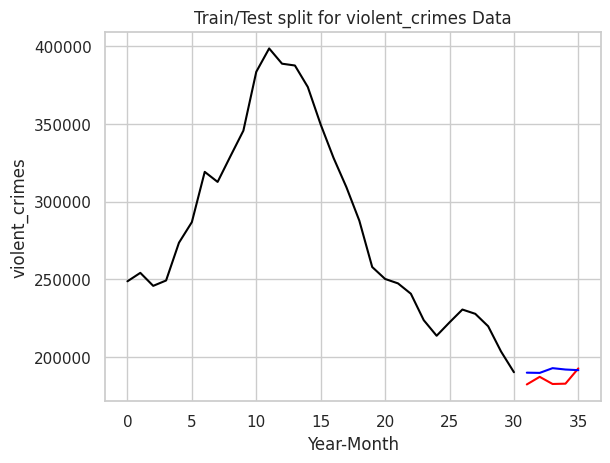

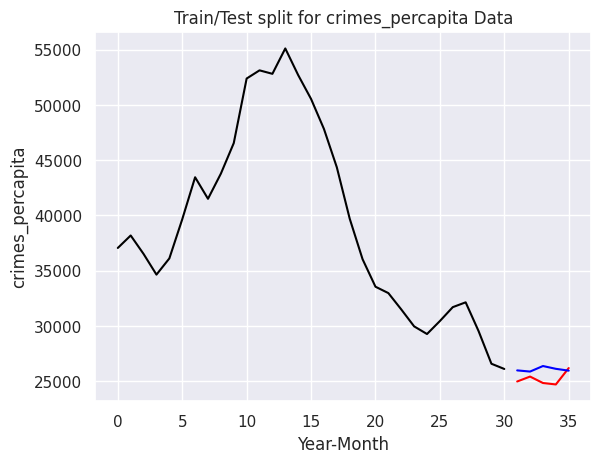

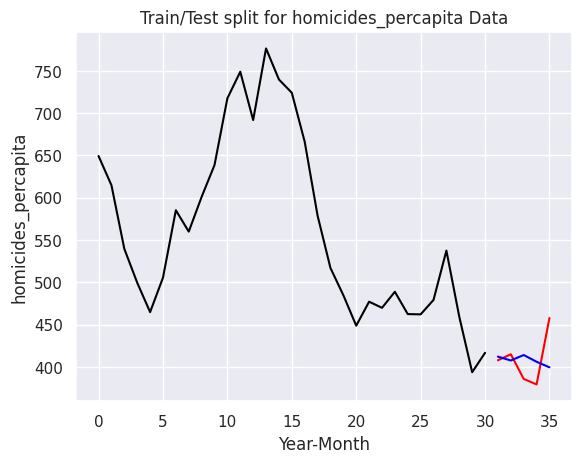

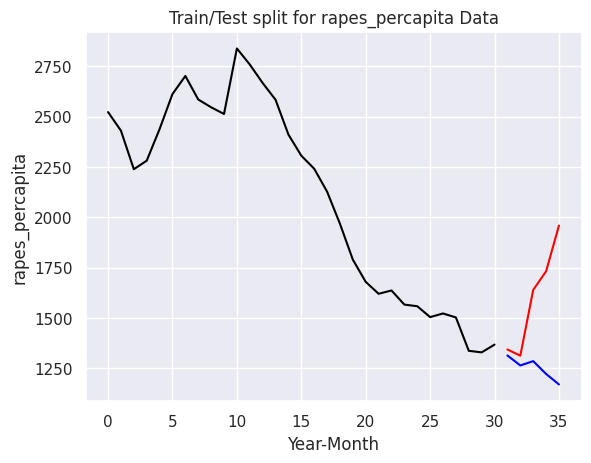

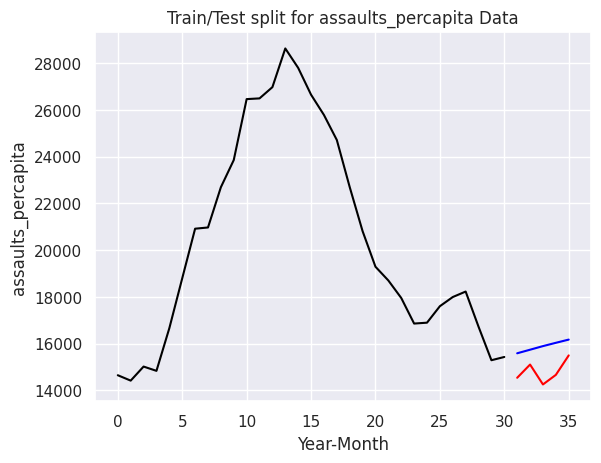

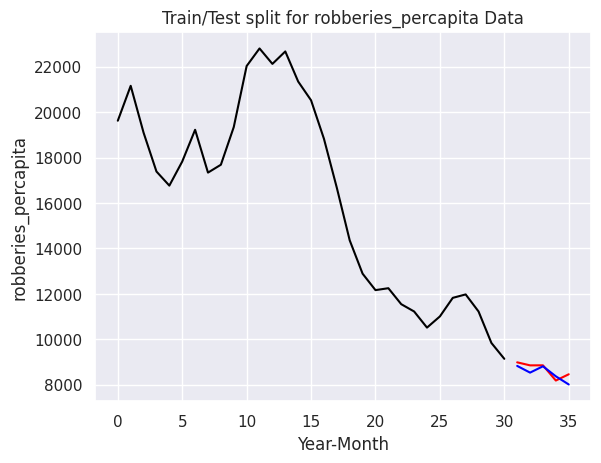

RMSE for violent_crimes 0.1163
RMSE for crimes_percapita 0.1234
RMSE for homicides_percapita 0.295
RMSE for rapes_percapita 0.91712
RMSE for assaults_percapita 0.25717
RMSE for robberies_percapita 0.06223
MAE for violent_crimes 0.10007
MAE for crimes_percapita 0.10797
MAE for homicides_percapita 0.2335
MAE for rapes_percapita 0.70607
MAE for assaults_percapita 0.24172
MAE for robberies_percapita 0.05322


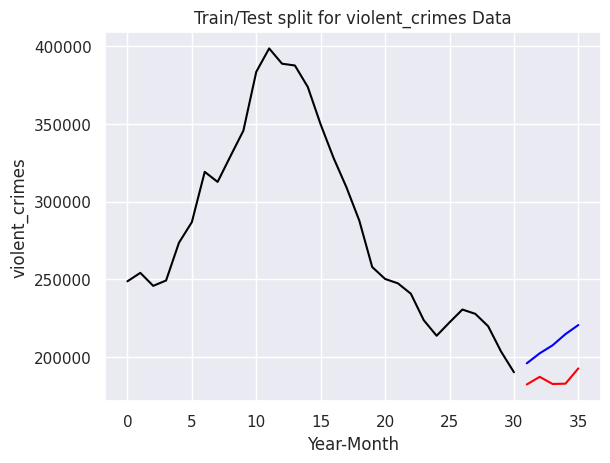

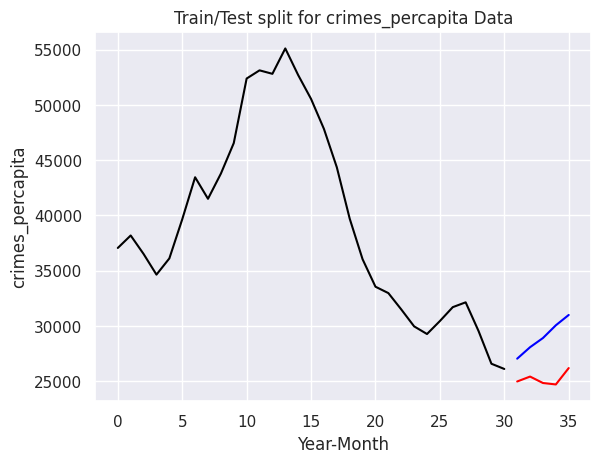

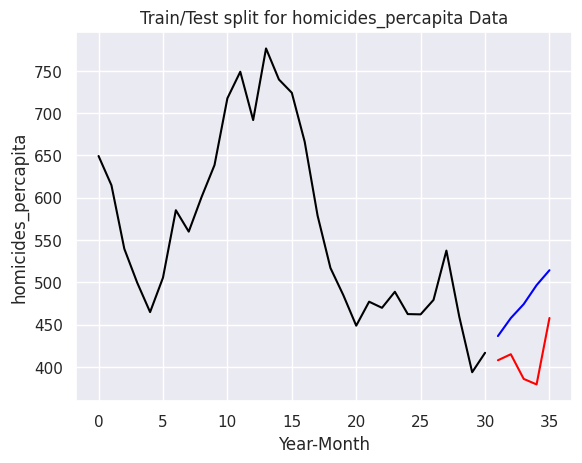

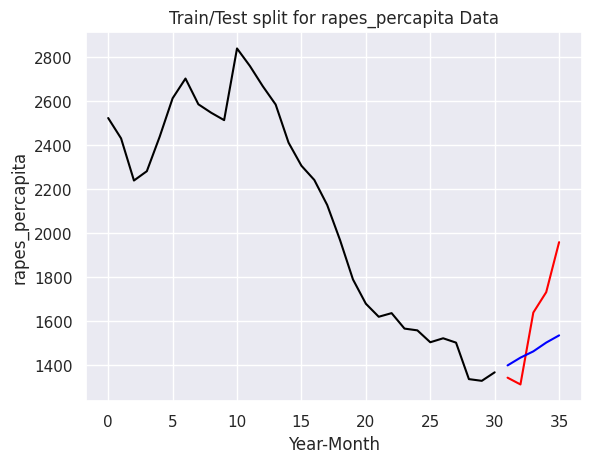

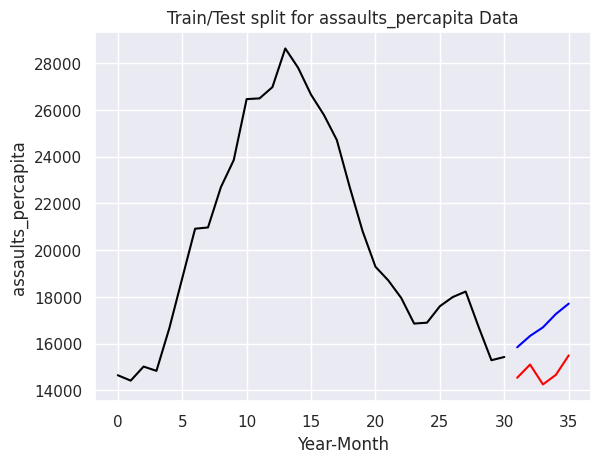

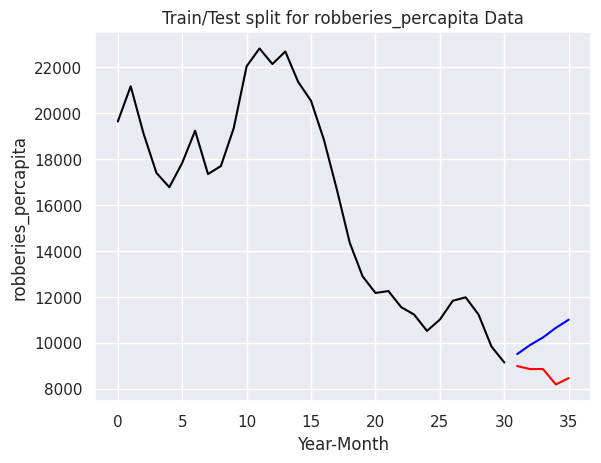

RMSE for violent_crimes 0.38997
RMSE for crimes_percapita 0.46424
RMSE for homicides_percapita 0.69146
RMSE for rapes_percapita 0.48328
RMSE for assaults_percapita 0.4595
RMSE for robberies_percapita 0.40993
MAE for violent_crimes 0.37188
MAE for crimes_percapita 0.44089
MAE for homicides_percapita 0.62294
MAE for rapes_percapita 0.41041
MAE for assaults_percapita 0.44056
MAE for robberies_percapita 0.36663


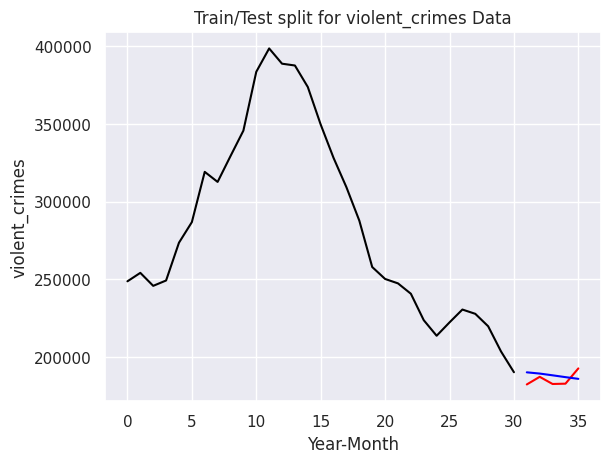

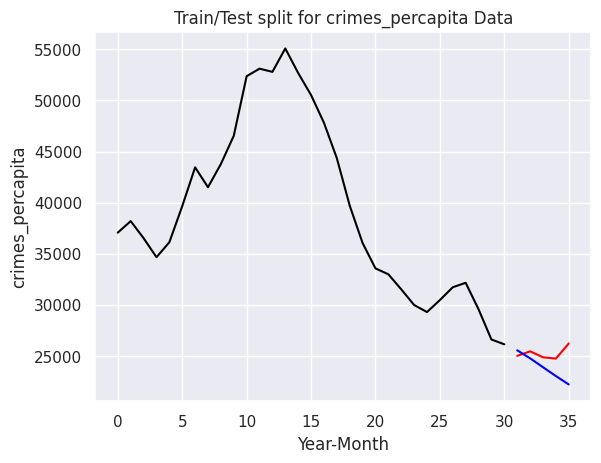

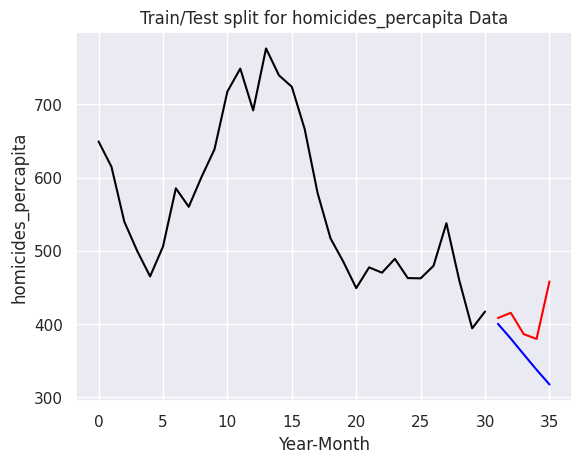

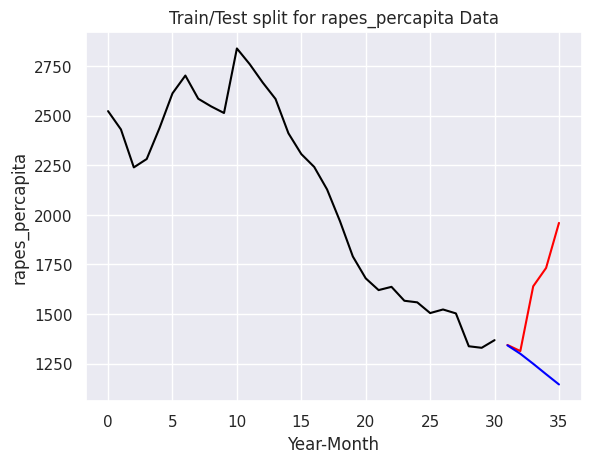

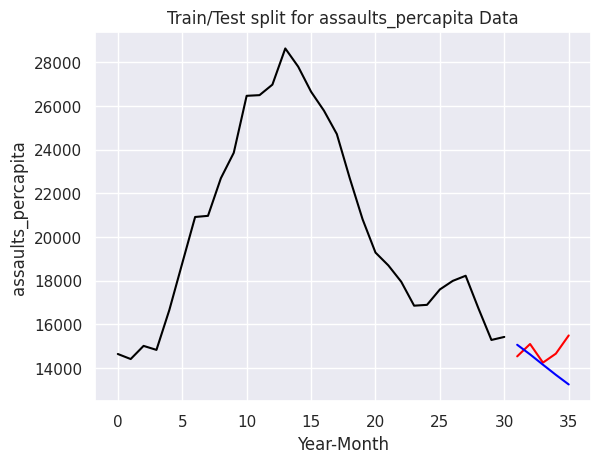

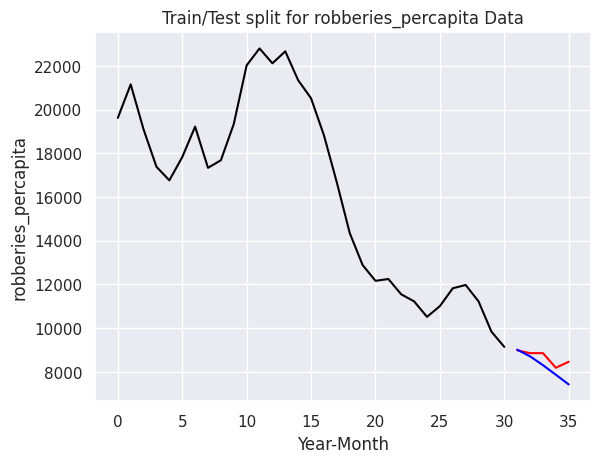

RMSE for violent_crimes 0.09251
RMSE for crimes_percapita 0.23693
RMSE for homicides_percapita 0.64262
RMSE for rapes_percapita 0.95812
RMSE for assaults_percapita 0.25622
RMSE for robberies_percapita 0.12666
MAE for violent_crimes 0.08658
MAE for crimes_percapita 0.18437
MAE for homicides_percapita 0.4741
MAE for rapes_percapita 0.7165
MAE for assaults_percapita 0.19405
MAE for robberies_percapita 0.09606


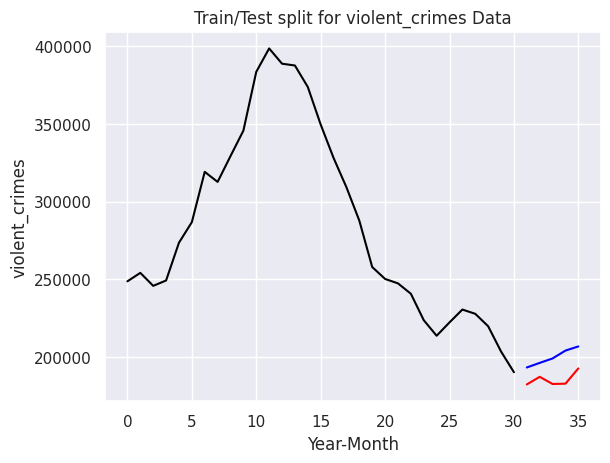

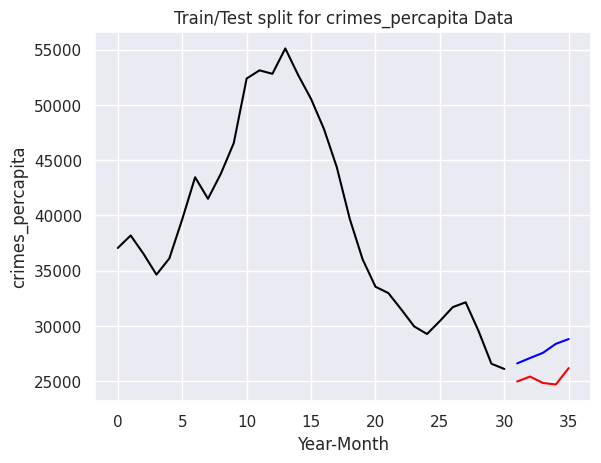

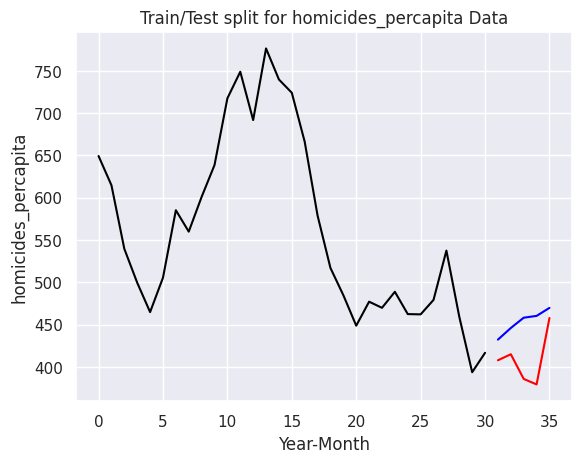

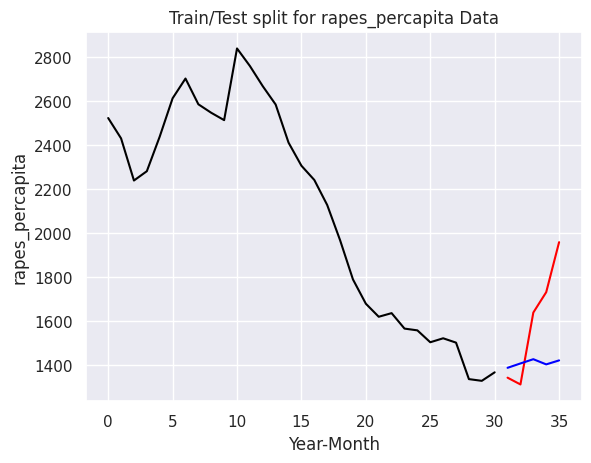

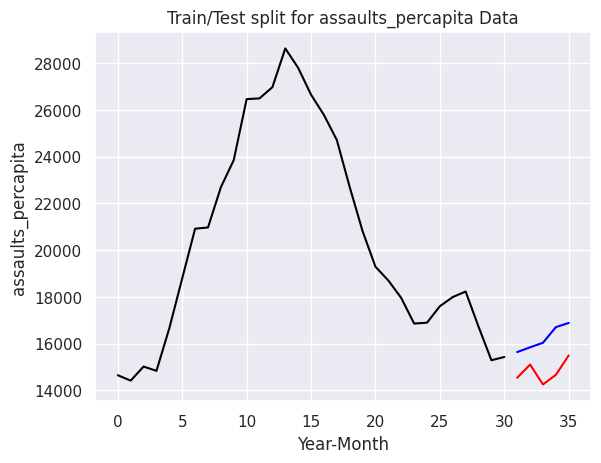

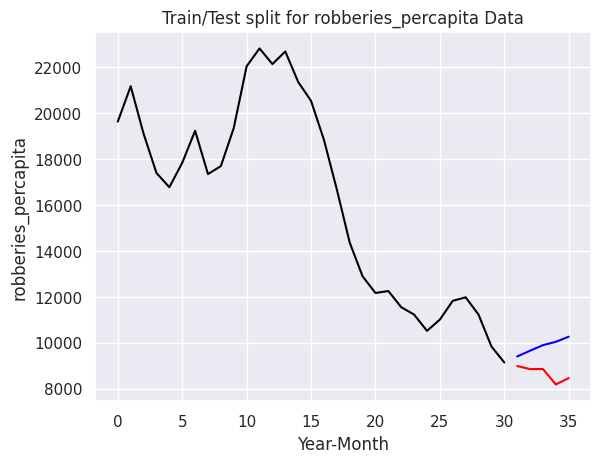

RMSE for violent_crimes 0.2457
RMSE for crimes_percapita 0.3004
RMSE for homicides_percapita 0.48521
RMSE for rapes_percapita 0.61319
RMSE for assaults_percapita 0.33428
RMSE for robberies_percapita 0.30226
MAE for violent_crimes 0.23527
MAE for crimes_percapita 0.28723
MAE for homicides_percapita 0.41227
MAE for rapes_percapita 0.49645
MAE for assaults_percapita 0.31737
MAE for robberies_percapita 0.27285


In [145]:
errors = {}
accs = {}

for j in[1,2,3,10] :
  errors = {}
  accs = {}
  for i in range(4, 10):
      # Extract the target variable and exogenous variable
      target_variable = train_time.iloc[:, i]
      exogenous_variable = train_time.iloc[:,j]

      # Fit SARIMAX model
      model = sm.tsa.SARIMAX(target_variable, exog=exogenous_variable)
      results = model.fit(disp=False)

      # Forecast
      forecast_steps = len(test_time)
      forecast = results.get_forecast(steps=forecast_steps, exog=test_time.iloc[:,j])

      # Calculate RMSE
      rms = sqrt(mean_squared_error(test_time.iloc[:, i], forecast.predicted_mean))
      errors[train_time.columns[i]] = round(rms,5)
      accs[train_time.columns[i]] = round(mean_absolute_error(test_time.iloc[:, i], forecast.predicted_mean),5)

      # Denormalize before plotting
      target_variable = target_variable * new_df.iloc[:,i].std() + new_df.iloc[:,i].mean()
      true_test_data = test_time.iloc[:, i] * new_df.iloc[:,i].std() + new_df.iloc[:,i].mean()
      forecasted_test_data = forecast.predicted_mean * new_df.iloc[:,i].std() + new_df.iloc[:,i].mean()
      # Plot the results
      plt.plot(target_variable, color="black")
      plt.plot(true_test_data, color="red")
      plt.plot(forecasted_test_data, color="blue")
      plt.title(f"Train/Test split for {train_time.columns[i]} Data")
      plt.ylabel(train_time.columns[i])
      plt.xlabel('Year-Month')
      sns.set()
      plt.show()

  for i in range(4,10):
    print(f'RMSE for {train_time.columns[i]}', errors[train_time.columns[i]])

  print("="*40)
  for i in range(4,10):
    print(f'MAE for {train_time.columns[i]}', accs[train_time.columns[i]])


Linear Regression using random split

For Target Variable violent_crimes
Mean Squared Error : 0.006440141067104823
R-squared: 0.9944193658905073


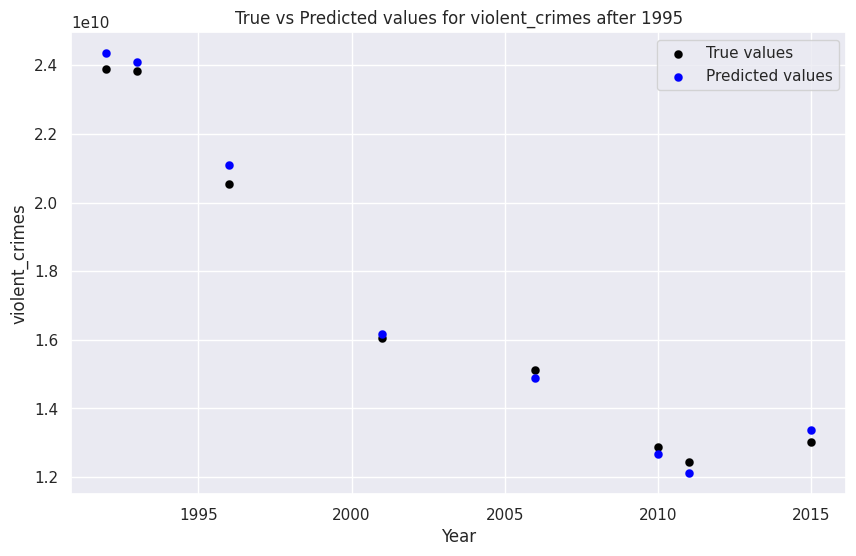



For Target Variable crimes_percapita
Mean Squared Error : 0.004172087064675249
R-squared: 0.9999991341614894


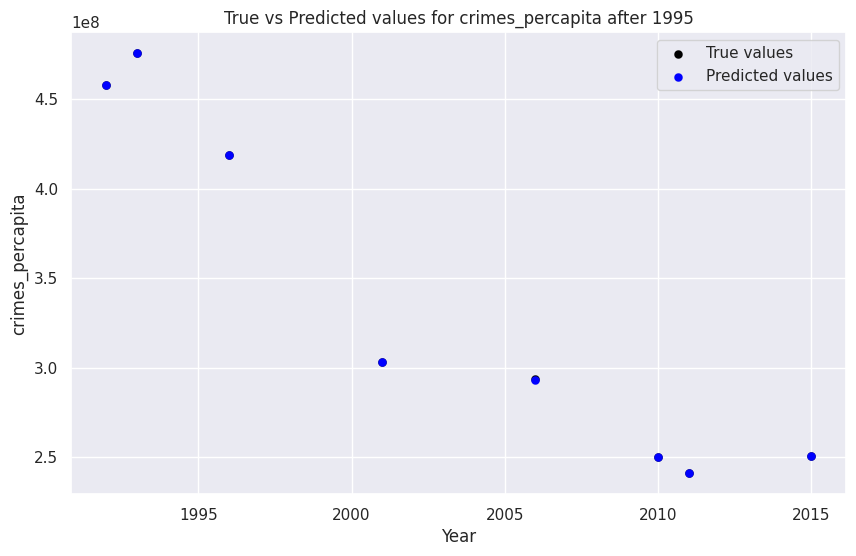



For Target Variable homicides_percapita
Mean Squared Error : 0.009180469216090212
R-squared: 0.9924679894869232


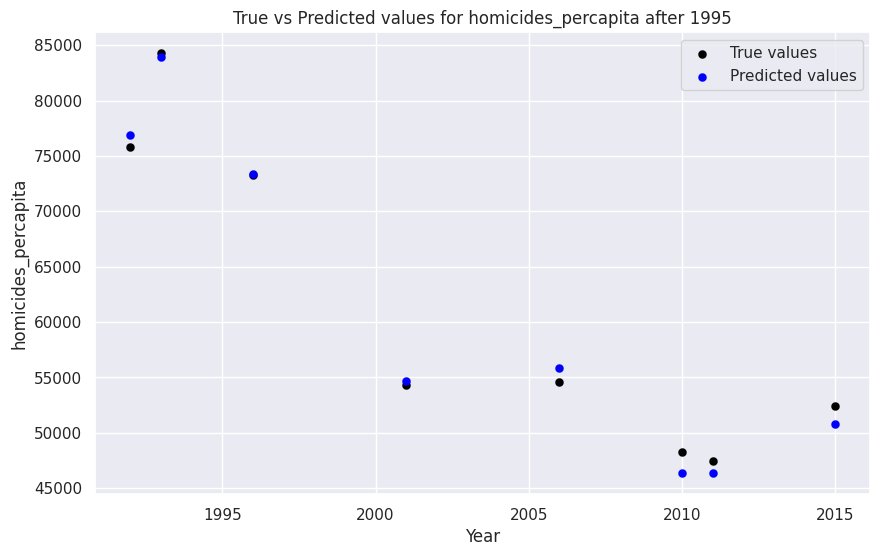



For Target Variable rapes_percapita
Mean Squared Error : 0.004488127914753644
R-squared: 0.9996457565467075


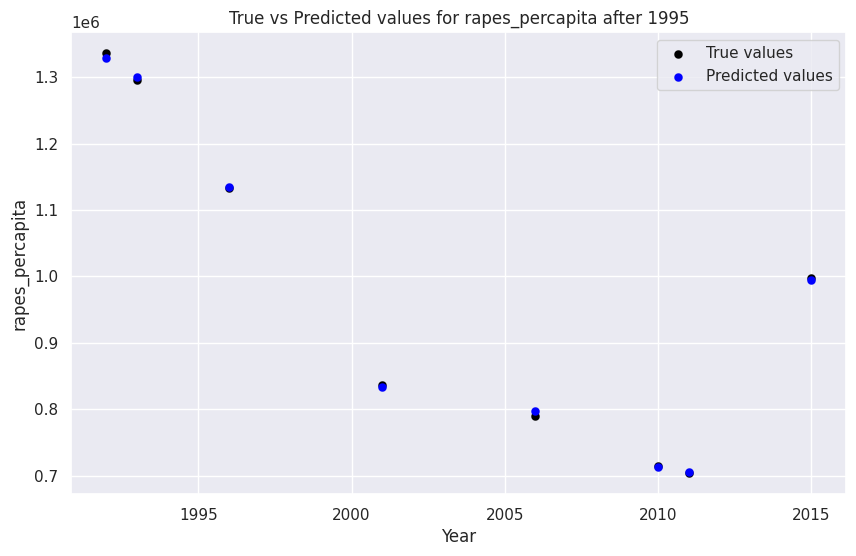



For Target Variable assaults_percapita
Mean Squared Error : 0.004174835781926591
R-squared: 0.9999961037154255


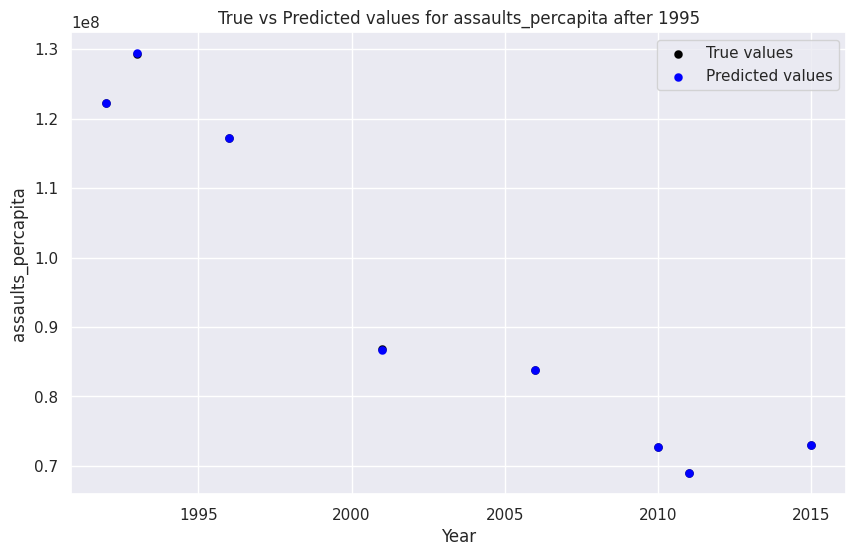



For Target Variable robberies_percapita
Mean Squared Error : 0.00417508842131466
R-squared: 0.9999957354453316


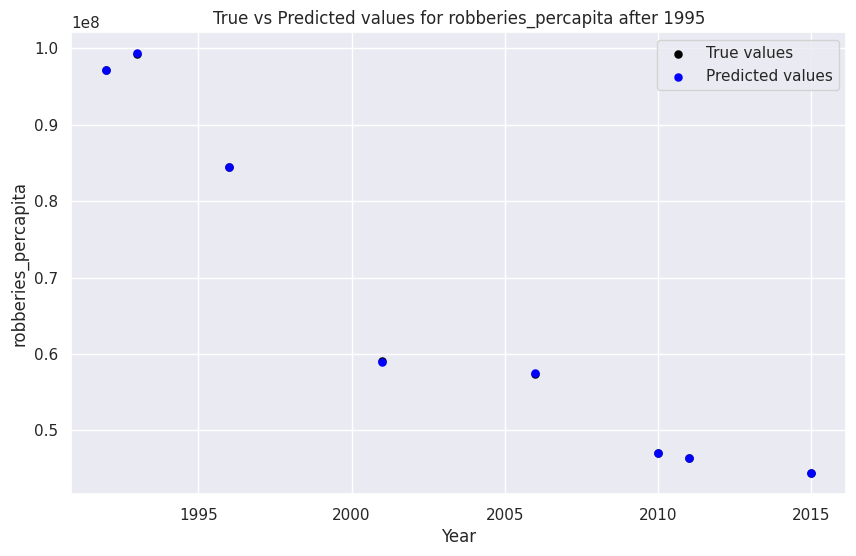

In [154]:
target_cols = ['violent_crimes', 'crimes_percapita', 'homicides_percapita', 'rapes_percapita', 'assaults_percapita', 'robberies_percapita']

for target_variable in target_cols:
    # Features (excluding the target variable and non-numeric columns)
    features = new_df.select_dtypes(include='number').columns.difference([target_variable, 'State', 'Year'])

    # Extracting features and target variable
    X = new_df[features]
    y = new_df[[target_variable]]

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_test = (X_test - X_train.mean())/X_train.std()
    X_train = (X_train - X_train.mean())/X_train.std()

    X_train["bias"] = 1
    X_test["bias"] = 1


    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(((y_test - y_test.mean())/y_test.std()), ((y_pred - y_pred.mean())/y_pred.std()))
    r2 = r2_score(y_test, y_pred)

    print(f'For Target Variable {target_variable}')
    print(f'Mean Squared Error : {mse}')
    print(f'R-squared: {r2}')

    # Plotting
    plt.figure(figsize=(10, 6))
    x = new_df.iloc[y_test.index]['Year']

    y_test = y_test * new_df[target_variable].std() + new_df[target_variable].mean()
    y_pred = y_pred * new_df[target_variable].std() + new_df[target_variable].mean()

    plt.scatter(x, y_test, color='black',linewidths=0.1, label='True values')
    plt.scatter(x, y_pred, color='blue', linewidths=0.1,label='Predicted values')
    plt.xlabel('Year')
    plt.ylabel(target_variable)
    plt.title(f'True vs Predicted values for {target_variable} after 1995')
    plt.legend()
    plt.show()

    print("\n")

Neural Network run on time series split data

In [147]:
model = Sequential()

input_size = 4
hidden_size = 20
output_size = 1

model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
model.add(Dense(output_size, activation='linear'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Print a summary of the model architecture
model.summary()

import numpy as np
selected_columns = ['Per Capita Income', 'Unemployment Rate', 'population', 'Gini Index']

input_data = train_time[selected_columns]
target_cols = ['violent_crimes',	'crimes_percapita',	'homicides_percapita',	'rapes_percapita',	'assaults_percapita',	'robberies_percapita']

final_plots = list()
for col in target_cols:
  target_data = train_time[col]

  # # Training the model
  epochs = 100
  batch_size = 32

  model.fit(train_time[selected_columns], train_time[col], epochs=epochs, batch_size=batch_size, verbose=1)

  # Evaluate the model on the test data
  test_loss = model.evaluate(test_time[selected_columns], test_time[col])
  print('Mean Squared Error on Test Data:', test_loss)

  # Alternatively, you can use predict to get predictions and then calculate metrics using external libraries like scikit-learn
  from sklearn.metrics import mean_squared_error
  predictions = model.predict(test_time[selected_columns])

  # Calculate Mean Squared Error using scikit-learn
  mse = mean_squared_error(test_time[col], predictions)
  print('Mean Squared Error using scikit-learn:', mse)



  predictions = list(chain(*predictions))
  x = train_time[col]
  x = x.tolist()
  x = x + predictions
  predictions = None
  final_plots.append(x)
  x = None



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                100       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 582ms/step - loss: 1.4630
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 1.4364
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 1.4104
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 1.3845
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 1.3590
Epoch 6/100
1/1 [=

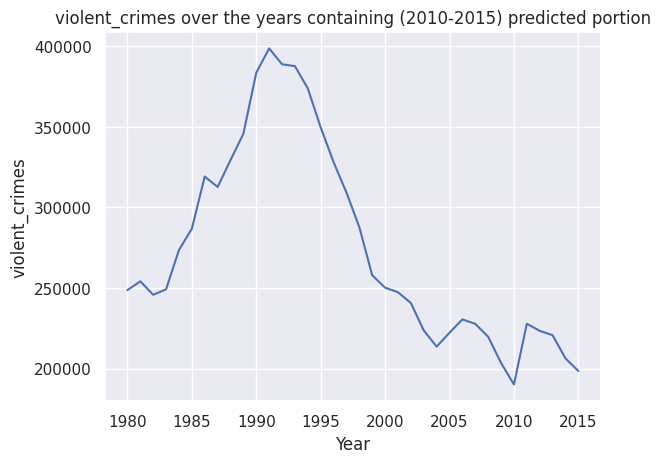

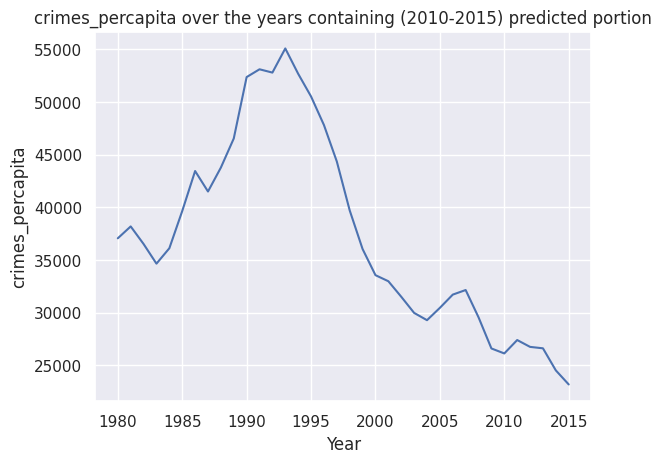

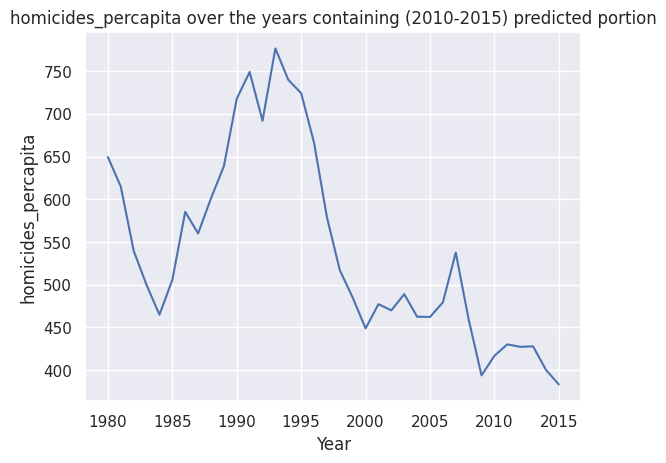

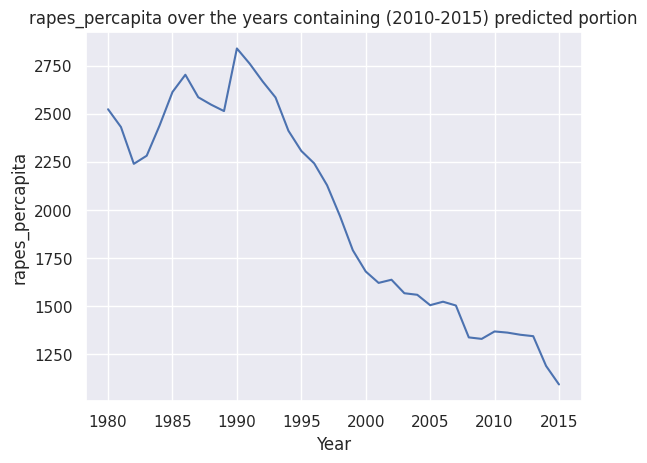

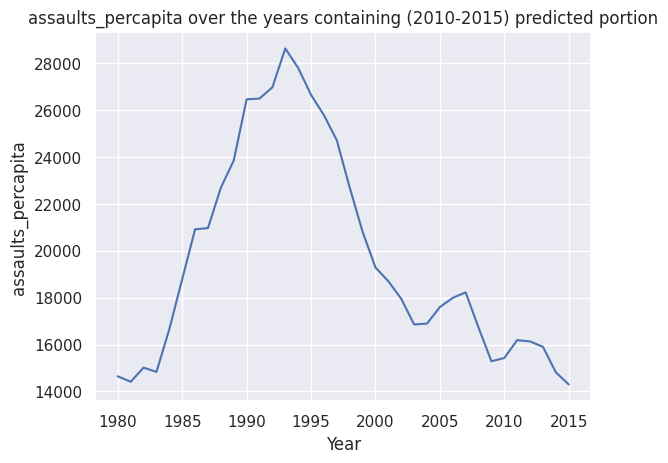

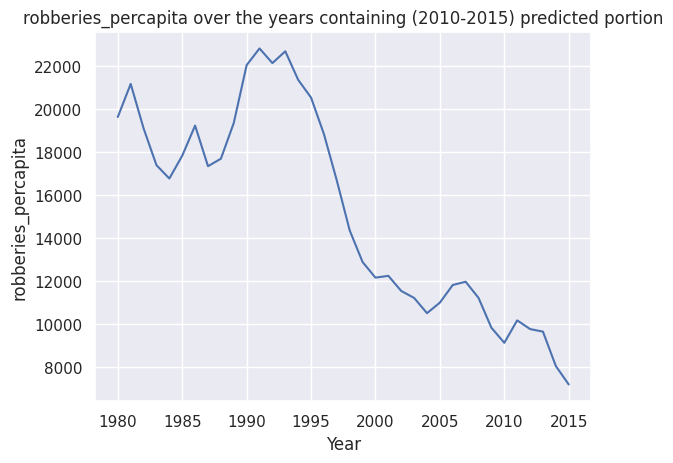

In [153]:
target_cols = ['violent_crimes',	'crimes_percapita',	'homicides_percapita',	'rapes_percapita',	'assaults_percapita',	'robberies_percapita']
x = 0

for col in target_cols:

  plt.figure()
  plt.plot(new_df['Year'], (np.multiply(final_plots[x],new_df[col].std()) + new_df[col].mean()))

  plt.xlabel('Year')
  plt.ylabel(col)
  plt.title(f'{col} over the years containing (2010-2015) predicted portion')

  # Show the plot
  plt.show()
  x = x + 1


# **Causal Inference**

In [149]:
display(merged_df)
THRESHOLD = 0.5

def print_ate_for_target_cols(effect_of):
  normalized_merged_df = merged_df.select_dtypes(include='number').apply(axis=0, func=lambda col: (col - col.mean())/col.std())
  target_cols = ['violent_crimes',	'crimes_percapita',	'homicides_percapita',	'rapes_percapita',	'assaults_percapita',	'robberies_percapita']
  for effect_on in target_cols:
    treatment = normalized_merged_df.iloc[normalized_merged_df[effect_of].sort_values(ascending=False).head(int(THRESHOLD * len(normalized_merged_df))).index]
    control = normalized_merged_df.iloc[normalized_merged_df[effect_of].sort_values(ascending=True).head(int(THRESHOLD * len(normalized_merged_df))).index]
    pval = ttest_ind(treatment[effect_on],control[effect_on]).pvalue
    print(f"ATE of {effect_of} on {effect_on}: ",treatment[effect_on].mean() - control[effect_on].mean())
    print(f" With p-value: {pval} \n")




print_ate_for_target_cols("Per Capita Income")
print_ate_for_target_cols("Unemployment Rate")
print_ate_for_target_cols("population")

State  Year  Per Capita Income  Unemployment Rate  \
0                  Arizona  1980             8606.0                6.6   
1               California  1980            10439.0                6.8   
2                 Colorado  1980             9590.0                5.8   
3     District of Columbia  1980            11388.0                7.4   
4                  Florida  1980             8980.0                6.1   
...                    ...   ...                ...                ...   
1183                 Texas  2015            41976.0                4.4   
1184                  Utah  2015            35392.0                3.6   
1185              Virginia  2015            44896.0                4.5   
1186            Washington  2015            46604.0                5.6   
1187             Wisconsin  2015            40515.0                4.6   

        population  violent_crimes  crimes_percapita  homicides_percapita  \
0     4.180173e+05     3472.000000        743.440000            10.490000   
1     8.150304e+05    11609.666667       1329.897778            21.440000   
2     3.237835e+05     3399.000000        967.845000            13.275000   
3     6.352330e+05    12772.000000       2010.600000            31.480000   
4     4.099048e+05     7238.000000       1929.644000            27.094000   
...            ...             ...               ...                  ...   
1183  1.126126e+06     7420.428571        573.517143             6.275714   
1184  1.919920e+05     1642.000000        855.240000             4.170000   
1185  7.772485e+05      800.000000        113.330000             2.735000   
1186  6.837000e+05     4093.000000        598.650000             3.360000   
1187  6.004000e+05     9583.000000       1596.100000            24.150000   

      rapes_percapita  assaults_percapita  robberies_percapita  Gini Index  
0           52.223333          440.896667           239.826667          34  
1           86.035556          536.422222           686.003333          34  
2          101.950000          499.945000           352.665000          34  
3           69.110000          509.420000          1400.590000          34  
4          104.014000          925.020000           873.516000          34  
...               ...                 ...                  ...         ...  
1183        55.677143          322.748571           188.812857          41  
1184       151.570000          455.230000           244.280000          41  
1185        17.275000           43.405000            49.920000          41  
1186        21.060000          350.150000           224.070000          41  
1187        72.620000          874.920000           624.420000          41  

[1188 rows x 12 columns]

ATE of Per Capita Income on violent_crimes:  -0.17543611996083308
 With p-value: 0.0024671428547916995 

ATE of Per Capita Income on crimes_percapita:  -0.47158425658721287
 With p-value: 1.7433475015579946e-16 

ATE of Per Capita Income on homicides_percapita:  -0.24081858121222383
 With p-value: 3.144571445963129e-05 

ATE of Per Capita Income on rapes_percapita:  -0.8561853072723031
 With p-value: 3.5273343960607186e-54 

ATE of Per Capita Income on assaults_percapita:  -0.2994299580646642
 With p-value: 2.1451024937672294e-07 

ATE of Per Capita Income on robberies_percapita:  -0.5350099768227519
 With p-value: 6.2270317581362074e-21 

ATE of Unemployment Rate on violent_crimes:  0.2614067641798935
 With p-value: 6.213298457505235e-06 

ATE of Unemployment Rate on crimes_percapita:  0.16715432658756862
 With p-value: 0.003879505171131395 

ATE of Unemployment Rate on homicides_percapita:  0.3297388815149681
 With p-value: 1.0696160938128717e-08 

ATE of Unemployment Rate on rapes_p

In [150]:
def print_state_conditioned_ate_for_target_cols(effect_of):
  normalized_merged_df = merged_df.select_dtypes(include='number').apply(axis=0, func=lambda col: (col - col.mean())/col.std())
  normalized_merged_df["State"] = merged_df["State"]
  target_cols = ['violent_crimes',	'crimes_percapita',	'homicides_percapita',	'rapes_percapita',	'assaults_percapita',	'robberies_percapita']
  for effect_on in target_cols:
    treatment = normalized_merged_df.iloc[normalized_merged_df[effect_of].sort_values(ascending=False).head(int(THRESHOLD * len(normalized_merged_df))).index]
    control = normalized_merged_df.iloc[normalized_merged_df[effect_of].sort_values(ascending=True).head(int(THRESHOLD * len(normalized_merged_df))).index]
    state_conditioned_ATE = 0
    for state in merged_df["State"].unique():
      treatment_state = treatment[treatment["State"] == state]
      control_state = control[control["State"] == state]
      if(len(treatment_state) == 0 or len(control_state)==0):
        # print(f"Skipping {state} for {effect_on} because data doesn't belong to both treatment and control.")
        continue
      CATE = treatment_state[effect_on].mean() - control_state[effect_on].mean()
      prob = len(merged_df[merged_df['State']==state])/len(merged_df)
      state_conditioned_ATE += prob * CATE
    print(f"State Conditioned ATE of {effect_of} on {effect_on}: ",state_conditioned_ATE)


print_state_conditioned_ate_for_target_cols("Per Capita Income")
print_state_conditioned_ate_for_target_cols("Unemployment Rate")
print_state_conditioned_ate_for_target_cols("population")


State Conditioned ATE of Per Capita Income on violent_crimes:  -0.25853732729011913
State Conditioned ATE of Per Capita Income on crimes_percapita:  -0.5420736698203054
State Conditioned ATE of Per Capita Income on homicides_percapita:  -0.29616609156560364
State Conditioned ATE of Per Capita Income on rapes_percapita:  -0.840813971140426
State Conditioned ATE of Per Capita Income on assaults_percapita:  -0.3218581089387644
State Conditioned ATE of Per Capita Income on robberies_percapita:  -0.6522178153564981
State Conditioned ATE of Unemployment Rate on violent_crimes:  -0.026159511278623704
State Conditioned ATE of Unemployment Rate on crimes_percapita:  -0.07089119139637239
State Conditioned ATE of Unemployment Rate on homicides_percapita:  -0.036668076881878335
State Conditioned ATE of Unemployment Rate on rapes_percapita:  0.019006168724172687
State Conditioned ATE of Unemployment Rate on assaults_percapita:  -0.19175286604189115
State Conditioned ATE of Unemployment Rate on robb

In [151]:
def print_year_conditioned_ate_for_target_cols(effect_of):
  normalized_merged_df = merged_df.select_dtypes(include='number').apply(axis=0, func=lambda col: (col - col.mean())/col.std())
  normalized_merged_df["Year"] = merged_df["Year"]
  target_cols = ['violent_crimes',	'crimes_percapita',	'homicides_percapita',	'rapes_percapita',	'assaults_percapita',	'robberies_percapita']
  for effect_on in target_cols:
    treatment = normalized_merged_df.iloc[normalized_merged_df[effect_of].sort_values(ascending=False).head(int(THRESHOLD * len(normalized_merged_df))).index]
    control = normalized_merged_df.iloc[normalized_merged_df[effect_of].sort_values(ascending=True).head(int(THRESHOLD * len(normalized_merged_df))).index]
    year_conditioned_ATE = 0
    for year in merged_df["Year"].unique():
      treatment_year = treatment[treatment["Year"] == year]
      control_year = control[control["Year"] == year]
      if(len(treatment_year) == 0 or len(control_year)==0):
        # print(f"Skipping {year} for {effect_on} because data doesn't belong to both treatment and control.")
        continue
      CATE = treatment_year[effect_on].mean() - control_year[effect_on].mean()
      prob = len(merged_df[merged_df['Year']==year])/len(merged_df)
      year_conditioned_ATE += prob * CATE
    print(f"year Conditioned ATE of {effect_of} on {effect_on}: ",year_conditioned_ATE)

print_year_conditioned_ate_for_target_cols("Per Capita Income")
print_year_conditioned_ate_for_target_cols("Unemployment Rate")
print_year_conditioned_ate_for_target_cols("population")


year Conditioned ATE of Per Capita Income on violent_crimes:  0.138314278633226
year Conditioned ATE of Per Capita Income on crimes_percapita:  0.2995030367896097
year Conditioned ATE of Per Capita Income on homicides_percapita:  0.3740730545719243
year Conditioned ATE of Per Capita Income on rapes_percapita:  -0.13852501109241425
year Conditioned ATE of Per Capita Income on assaults_percapita:  0.1941821531694868
year Conditioned ATE of Per Capita Income on robberies_percapita:  0.3909786945739348
year Conditioned ATE of Unemployment Rate on violent_crimes:  0.46651591065640585
year Conditioned ATE of Unemployment Rate on crimes_percapita:  0.43862930534201494
year Conditioned ATE of Unemployment Rate on homicides_percapita:  0.6556646214096912
year Conditioned ATE of Unemployment Rate on rapes_percapita:  -0.10743166123409235
year Conditioned ATE of Unemployment Rate on assaults_percapita:  0.36267407778531274
year Conditioned ATE of Unemployment Rate on robberies_percapita:  0.47389